In [42]:
# Core libraries
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    SMOTE = None
    warnings.warn("imblearn not available. Install with `pip install imbalanced-learn` to enable SMOTE demos.")

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

In [43]:
# Import the Path class from pathlib to handle file paths easily
ctg_path = Path("ctg.xlsx")

# Check that the Excel file actually exists at the given path.
# If not, raise an AssertionError with a descriptive message.
assert ctg_path.exists(), f"Expected Excel file at {ctg_path}"


def read_feature_sheet(path: Path, sheet=0):
    """
    Load the CTG (Cardiotocography) feature sheet from the Excel file.

    Parameters:
        path (Path): The path to the Excel file.
        sheet (int or str): The sheet index (default 0) or sheet name to read.

    Returns:
        pandas.DataFrame: The contents of the specified sheet.
    """
    # Load the Excel file into a pandas ExcelFile object for easy sheet access
    xlsx = pd.ExcelFile(path)

    # If 'sheet' is given as an index (integer), convert it to the sheet name
    if isinstance(sheet, int):
        sheet_name = xlsx.sheet_names[sheet]
    else:
        # Otherwise, use the provided sheet name directly
        sheet_name = sheet

    try:
        # Try reading the sheet with header on the second row (index 1),
        # assuming the first row may contain metadata or titles.
        df = pd.read_excel(xlsx, sheet_name=sheet_name, header=1)
    except ValueError:
        # If that fails (e.g., unexpected format), fall back to using the first row as header.
        df = pd.read_excel(xlsx, sheet_name=sheet_name, header=0)

    # Return the DataFrame with the loaded data
    return df


# Read the second sheet (index 1) from the Excel file using the function above.
sheet2_raw = read_feature_sheet(ctg_path, sheet=1)

# Print out all sheet names found in the Excel file for reference
print("Sheets detected:", pd.ExcelFile(ctg_path).sheet_names)

# Print the shape (rows, columns) of the loaded feature sheet to verify its size
print("Feature sheet shape:", sheet2_raw.shape)

Sheets detected: ['Description', 'Data', 'Raw Data']
Feature sheet shape: (2129, 46)


In [44]:
import pandas as pd

def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and tidy up a DataFrame by:
    - Dropping blank rows and columns
    - Removing 'Unnamed' placeholder columns
    - Deduplicating column names
    - Renaming certain columns for consistency
    """
    # Make a copy of the input DataFrame to avoid modifying the original
    cleaned = df.copy()

    # Strip leading/trailing whitespace from all column names and ensure they are strings
    cleaned.columns = [str(col).strip() for col in cleaned.columns]

    # Drop any rows and columns that are entirely blank (all NaN)
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')

    # Remove columns whose names start with 'Unnamed' (common when Excel has empty columns)
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]

    # Remove duplicate column names, keeping the first occurrence
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]

    # Define a mapping of inconsistent column names to their cleaned versions
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',  # Note the trailing space in the original name
        'TENDENCY': 'Tendency'
    }

    # Rename columns if they appear in the DataFrame
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})

    # Return the cleaned and standardized DataFrame
    return cleaned


# Apply the tidying function to the raw sheet loaded earlier
sheet2 = tidy_sheet(sheet2_raw)


# Define the name of the target variable (the column to predict)
target_col = 'NSP'  # NSP usually stands for Normal/Suspect/Pathologic class in CTG datasets

# Define columns that could "leak" label information if included as features.
# These are often derived from or correlated with the target labels, so they should be excluded.
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']

# Filter the list to keep only columns that actually exist in the cleaned DataFrame
label_leak_cols = [col for col in label_leak_cols if col in sheet2.columns]


# Display the first few rows of the cleaned dataset to inspect the result
sheet2.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,-1.00,9.00,2.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,2.00,1.00


In [45]:
# Get the shape (number of rows and columns) of the cleaned DataFrame.
# Returns a tuple: (num_rows, num_columns)
sheet2_shape = sheet2.shape

# Display a concise summary of the DataFrame, including:
# - Column names
# - Non-null counts
# - Data types for each column
# This is useful for quickly checking data quality and types.
sheet2_info = sheet2.info()

# Generate descriptive statistics for all columns (numeric and non-numeric)
# .describe(include='all') gives summary stats like count, mean, std, min, max for numeric,
# and count, unique, top, freq for categorical columns.
# The .T transposes the output for easier reading (columns become rows).
# .head(30) limits the display to the first 30 rows of this transposed summary.
sheet2.describe(include='all').T.head(30)

<class 'pandas.core.frame.DataFrame'>
Index: 2128 entries, 0 to 2128
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   float64
 1   e         2126 non-null   float64
 2   AC        2126 non-null   float64
 3   FM        2127 non-null   float64
 4   UC        2127 non-null   float64
 5   DL        2128 non-null   float64
 6   DS        2128 non-null   float64
 7   DP        2128 non-null   float64
 8   DR        2128 non-null   float64
 9   LB        2126 non-null   float64
 10  AC.1      2126 non-null   float64
 11  FM.1      2127 non-null   float64
 12  UC.1      2127 non-null   float64
 13  DL.1      2128 non-null   float64
 14  DS.1      2128 non-null   float64
 15  DP.1      2128 non-null   float64
 16  ASTV      2127 non-null   float64
 17  mSTV      2127 non-null   float64
 18  ALTV      2127 non-null   float64
 19  mLTV      2127 non-null   float64
 20  Width     2126 non-null   float64
 

,count,mean,std,min,25%,50%,75%,max
b,"2,126.00",878.44,894.08,0.00,55.00,538.00,"1,521.00","3,296.00"
e,"2,126.00","1,702.88",930.92,287.00,"1,009.00","1,241.00","2,434.75","3,599.00"
AC,"2,126.00",2.72,3.56,0.00,0.00,1.00,4.00,26.00
FM,"2,127.00",7.50,39.03,0.00,0.00,0.00,2.00,564.00
UC,"2,127.00",3.67,2.88,0.00,1.00,3.00,5.00,23.00
DL,"2,128.00",1.58,2.52,0.00,0.00,0.00,3.00,16.00
DS,"2,128.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
DP,"2,128.00",0.13,0.47,0.00,0.00,0.00,0.00,4.00
DR,"2,128.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
LB,"2,126.00",133.30,9.84,106.00,126.00,133.00,140.00,160.00


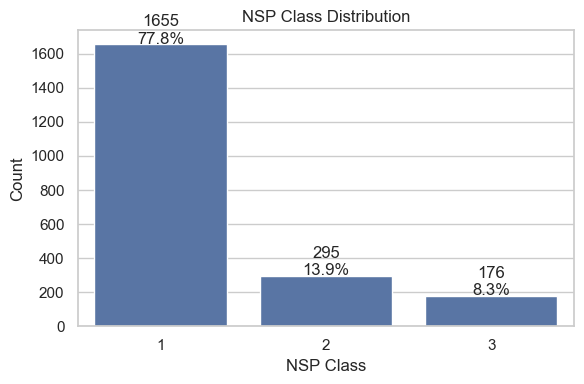

,Class,Count,Proportion
0,1,1655,0.78
1,2,295,0.14
2,3,176,0.08


In [46]:
# Count how many samples belong to each class in the target column (NSP)
# and sort the counts by class index (e.g., 1 = Normal, 2 = Suspect, 3 = Pathologic)
class_counts = sheet2[target_col].value_counts().sort_index()

# Calculate the proportion (percentage) of each class relative to the total number of samples
class_props = class_counts / class_counts.sum()


# Create a new Matplotlib figure and axis with a fixed size
fig, ax = plt.subplots(figsize=(6, 4))

# Use Seaborn to create a bar plot showing the counts for each class
sns.barplot(x=class_counts.index.astype(int),  # x-axis: class labels (e.g., 1, 2, 3)
            y=class_counts.values,             # y-axis: count of samples per class
            ax=ax)

# Set the x-axis label
ax.set_xlabel('NSP Class')

# Set the y-axis label
ax.set_ylabel('Count')

# Add a title to the chart
ax.set_title('NSP Class Distribution')

# Add count + proportion labels on top of each bar
for index, value in enumerate(class_counts.values):
    # Create a label that shows both the raw count and the percentage (e.g., "123\n45.6%")
    label = f"{value}\n{class_props.iloc[index]:.1%}"
    # Place the text slightly above the bar, centered horizontally
    ax.text(index, value + 5, label, ha='center')

# Adjust the layout to prevent labels from overlapping or being cut off
plt.tight_layout()

# Display the bar plot
plt.show()


# Create a DataFrame that summarizes the class distribution numerically.
# This table shows:
# - The class label (e.g., 1, 2, 3)
# - The count of samples in each class
# - The proportion of each class as a decimal
pd.DataFrame({
    'Class': class_counts.index.astype(int),
    'Count': class_counts.values,
    'Proportion': class_props.values
})


In [47]:
# Check for missing values (NaN) in the DataFrame.
# .isna() returns a DataFrame of booleans (True where values are NaN).
# .sum() counts the number of True values per column → total missing values per column.
missing_summary = sheet2.isna().sum().sort_values(ascending=False)

# Filter the summary to show only columns that have at least 1 missing value.
# This helps focus on the columns that need cleaning or imputation.
missing_summary[missing_summary > 0]


b           2
Width       2
CLASS       2
Tendency    2
Variance    2
Median      2
Mean        2
Mode        2
Nzeros      2
Nmax        2
Max         2
e           2
Min         2
NSP         2
AC          2
AC.1        2
LB          2
LD          1
D           1
C           1
B           1
A           1
FM          1
UC          1
DE          1
SUSP        1
FS          1
AD          1
FM.1        1
UC.1        1
mLTV        1
ALTV        1
mSTV        1
ASTV        1
E           1
dtype: int64

In [48]:
# Choose a demo feature to work with:
# - If 'ASTV' (percentage of time with abnormal short term variability) exists, use it.
# - Otherwise, pick the first numeric (float) column available in the dataset.
demo_feature = 'ASTV' if 'ASTV' in sheet2.columns else sheet2.select_dtypes(float).columns[0]

# Create a copy of just the selected feature as a separate DataFrame for demonstration
demo_df = sheet2[[demo_feature]].copy()

# Initialize a random number generator with a fixed seed for reproducibility
rng = np.random.default_rng(42)

# Randomly select 5 row indices from the demo_df to artificially introduce missing values
mask_indices = rng.choice(demo_df.index, size=5, replace=False)

# Set the selected rows' values to NaN to simulate missing data
demo_df.loc[mask_indices, demo_feature] = np.nan

# Store the values at those indices before imputation (should contain NaNs)
before_impute = demo_df.loc[mask_indices]

# Impute (fill in) missing values using the **median** of the column.
# This is a common technique for handling missing numeric data.
demo_df[demo_feature] = demo_df[demo_feature].fillna(demo_df[demo_feature].median())

# Store the values at those same indices after imputation
after_impute = demo_df.loc[mask_indices]

# Create a comparison table showing:
# - Which indices were imputed
# - Their values before (NaN) and after (median value) imputation
pd.DataFrame({
    'Index': mask_indices,
    'Before': before_impute.squeeze().values,
    'After': after_impute.squeeze().values
}) 


,Index,Before,After
0,1644,NaN,49.00
1,933,NaN,49.00
2,1391,NaN,49.00
3,189,NaN,49.00
4,921,NaN,49.00


In [49]:
# Check for duplicate rows in the DataFrame.
# .duplicated() returns a boolean Series where True indicates a row that is a duplicate of a previous row.
# .sum() counts the number of True values, i.e., the total number of duplicate rows.
duplicate_rows = sheet2.duplicated().sum()

# Display the total number of duplicate rows found in the dataset.
duplicate_rows


10

In [50]:
# Assign the list of columns that may cause label leakage to a variable
columns_to_drop = label_leak_cols

# Print the columns that are going to be dropped to inform the user
print('Dropping label leakage columns:', columns_to_drop)

# Create a new DataFrame by dropping the specified columns from sheet2
# errors='ignore' ensures that if any column in columns_to_drop does not exist in sheet2, it won't raise an error
clean_df = sheet2.drop(columns=columns_to_drop, errors='ignore')

# Display the first few rows of the cleaned DataFrame to verify the changes
clean_df.head()

Dropping label leakage columns: ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,62.00,126.00,2.00,0.00,120.00,137.00,121.00,73.00,1.00,2.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,68.00,198.00,6.00,1.00,141.00,136.00,140.00,12.00,0.00,1.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,68.00,198.00,5.00,1.00,141.00,135.00,138.00,13.00,0.00,1.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,53.00,170.00,11.00,0.00,137.00,134.00,137.00,13.00,1.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,53.00,170.00,9.00,0.00,137.00,136.00,138.00,11.00,1.00,1.00


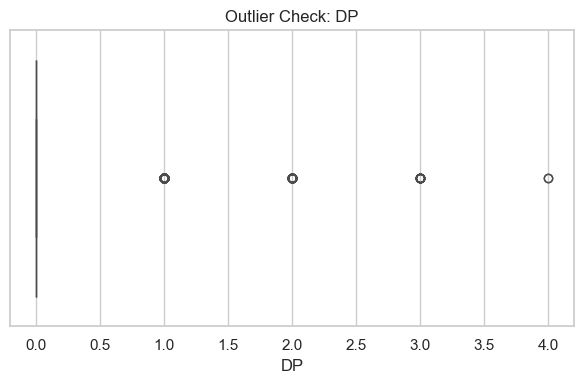

,DP,NSP
5,2.00,3.00
6,2.00,3.00
20,3.00,3.00
22,2.00,3.00
662,2.00,2.00


In [51]:
# Select the feature to check for outliers: use 'DP' if it exists, otherwise take the first physiological feature
outlier_feature = 'DP' if 'DP' in sheet2.columns else available_features['physiological'][0]

# Create a figure and axes for the boxplot with a specified size
fig, ax = plt.subplots(figsize=(6, 4))

# Plot a boxplot of the selected feature to visually inspect for outliers
sns.boxplot(x=sheet2[outlier_feature], ax=ax)

# Set the title of the plot to indicate which feature is being checked
ax.set_title(f'Outlier Check: {outlier_feature}')

# Adjust layout to prevent clipping of labels or titles
plt.tight_layout()

# Display the boxplot
plt.show()

# Compute the z-scores for the selected feature, ignoring any missing values
dp_scores = stats.zscore(sheet2[outlier_feature].dropna())

# Identify indices where the absolute z-score is greater than 3 (common threshold for outliers)
outlier_mask = np.abs(dp_scores) > 3

# Get the original indices of the outlier rows in the DataFrame
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]

# Display the outlier rows along with the feature and target column for inspection
sheet2.loc[outlier_indices, [outlier_feature, target_col]].head()


In [52]:
# Count the occurrences of each unique value in the selected feature and display the top 5 most frequent values
sheet2[outlier_feature].value_counts().head()

DP
0.00    1949
1.00     109
2.00      49
3.00      19
4.00       2
Name: count, dtype: int64

In [53]:
# Define groups of features based on their types for easier organization and analysis
feature_groups = {
    'physiological': ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'],  # Basic physiological measurements
    'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],       # Variability-related features
    'histogram': ['Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency'],  # Histogram/statistical features
    'timing': ['b', 'e'],                                   # Timing features (e.g., begin and end times)
    'baseline': ['LBE', 'LB']                               # Baseline measurements
}

# Filter each feature group to only include columns that actually exist in the DataFrame
available_features = {group: [col for col in cols if col in sheet2.columns]
                      for group, cols in feature_groups.items()}

# Display the available features in each group that are present in sheet2
available_features


{'physiological': ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'],
 'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],
 'histogram': ['Width',
  'Min',
  'Max',
  'Nmax',
  'Nzeros',
  'Mode',
  'Mean',
  'Median',
  'Variance',
  'Tendency'],
 'timing': ['b', 'e'],
 'baseline': ['LB']}

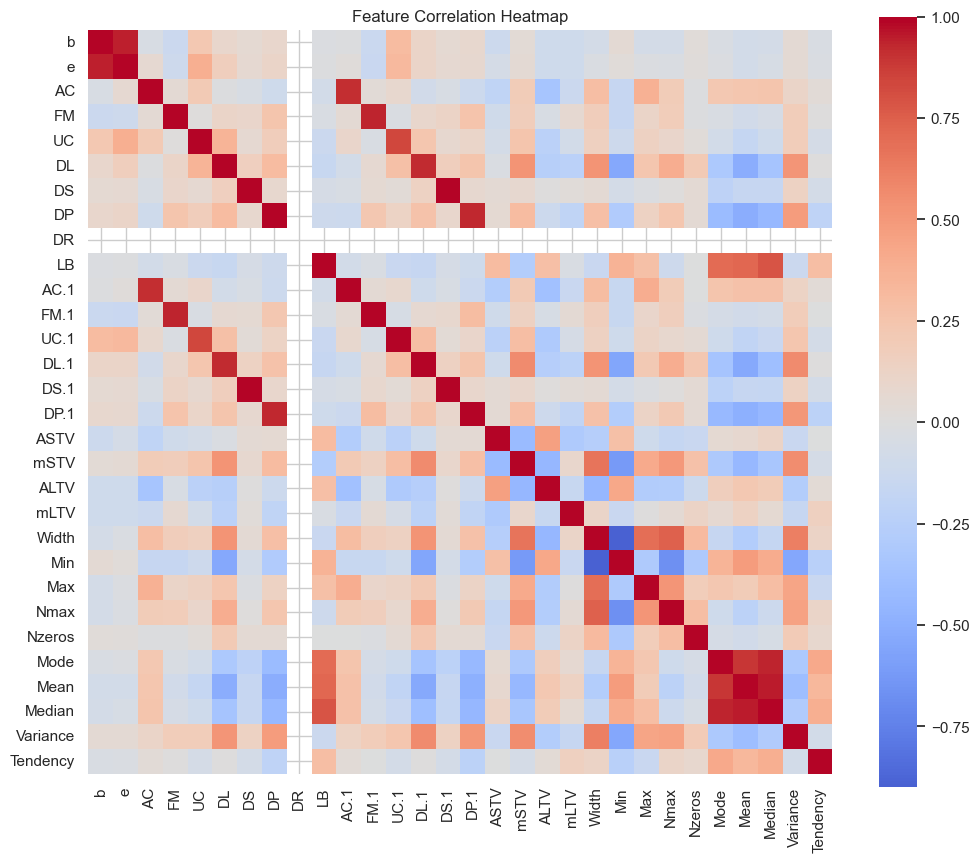

DS     DS.1     0.99
Mean   Median   0.95
b      e        0.94
FM     FM.1     0.94
Mode   Median   0.93
DP     DP.1     0.93
DL     DL.1     0.92
AC     AC.1     0.91
Width  Min      0.90
Mode   Mean     0.89
dtype: float64

In [54]:
# Select only numerical features from the cleaned DataFrame, excluding the target column
corr_features = clean_df.select_dtypes(include=[np.number]).drop(columns=[target_col])

# Compute the Pearson correlation matrix for the selected numerical features
corr_matrix = corr_features.corr(method='pearson')

# Create a figure for the heatmap with specified size
plt.figure(figsize=(12, 10))

# Plot a heatmap of the correlation matrix
# cmap='coolwarm' sets the color scheme, center=0 ensures neutral correlation is centered, square=True makes cells square
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)

# Set the title of the heatmap
plt.title('Feature Correlation Heatmap')

# Display the heatmap
plt.show()

# Get the upper triangle of the correlation matrix (to avoid duplicate pairs and self-correlation)
corr_pairs = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Flatten the upper triangle matrix, sort the correlation values in descending order, and show the top 10 strongest correlations
corr_pairs.stack().sort_values(ascending=False).head(10)


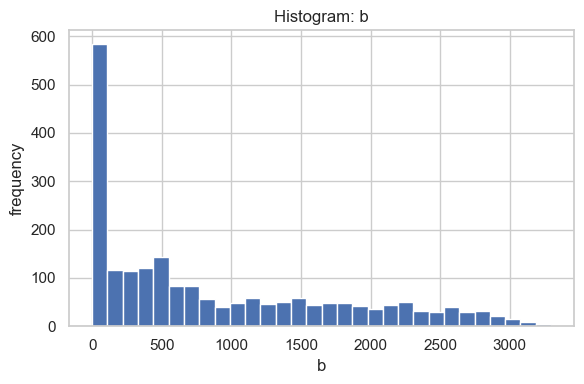

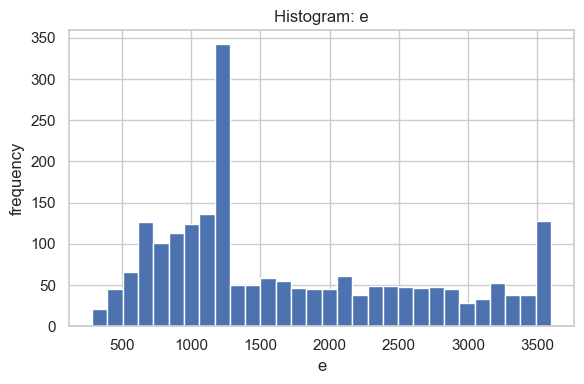

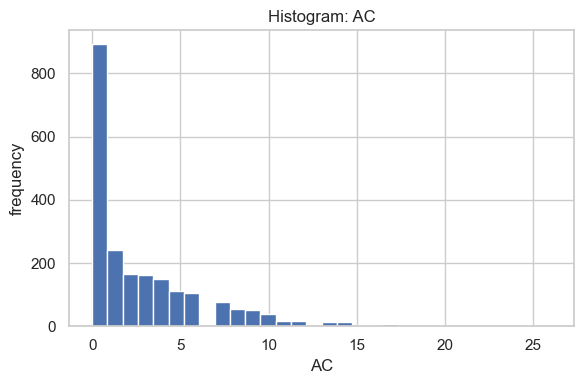

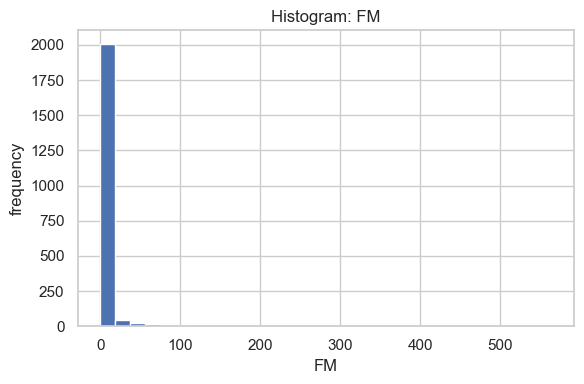

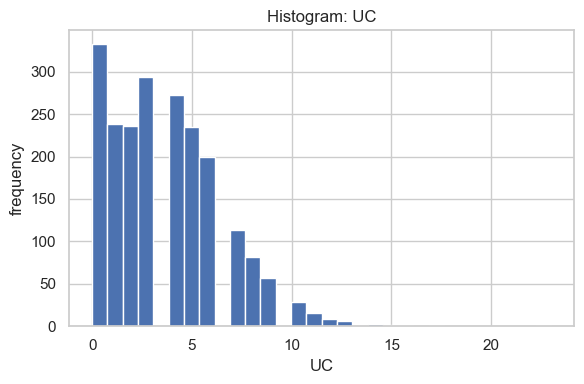

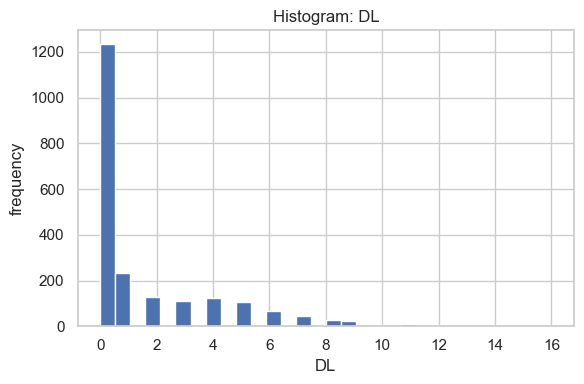

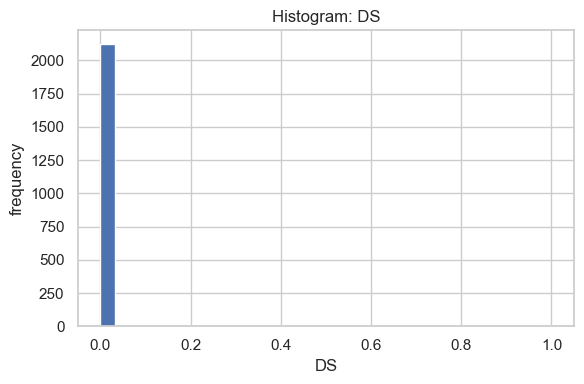

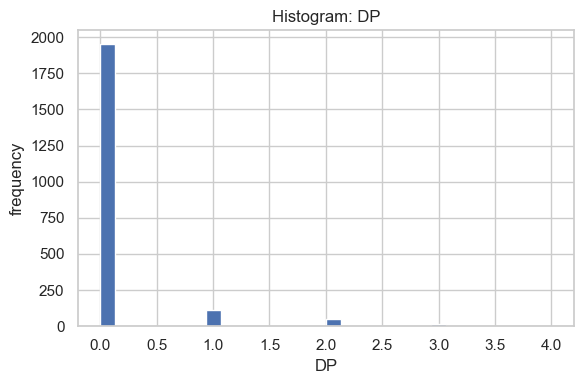

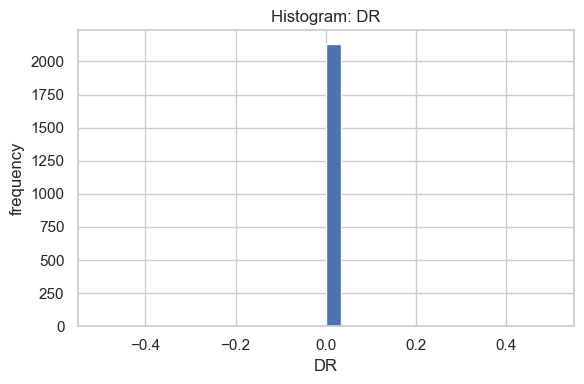

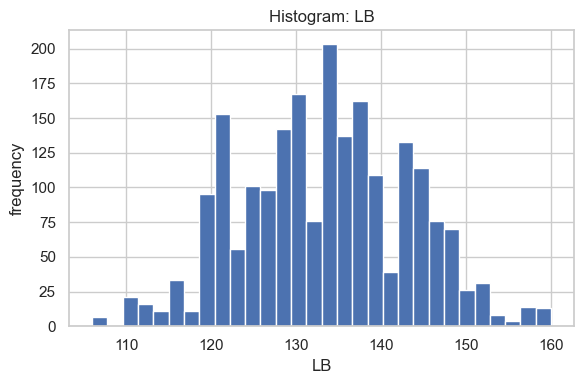

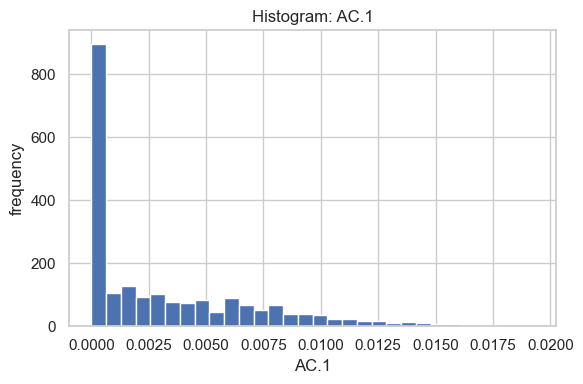

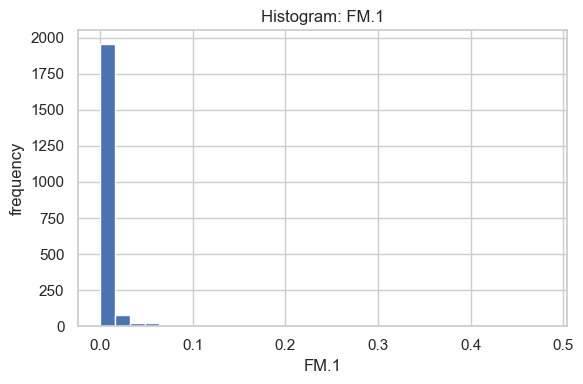

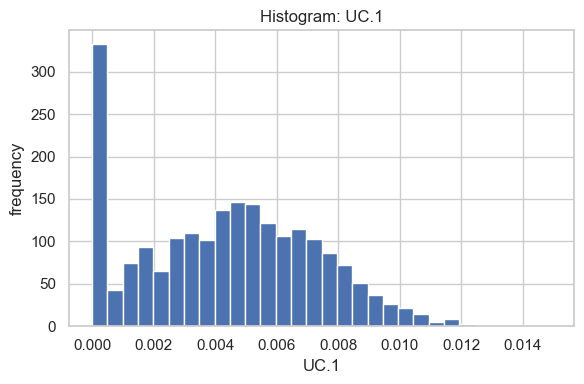

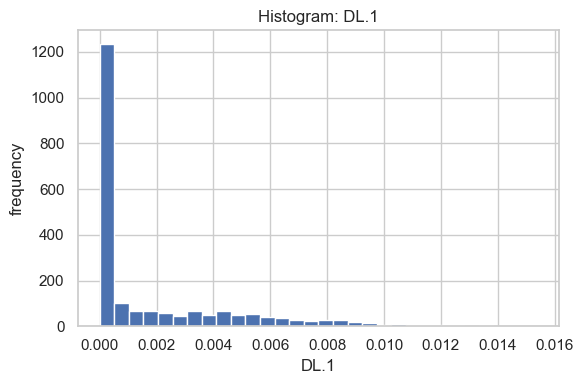

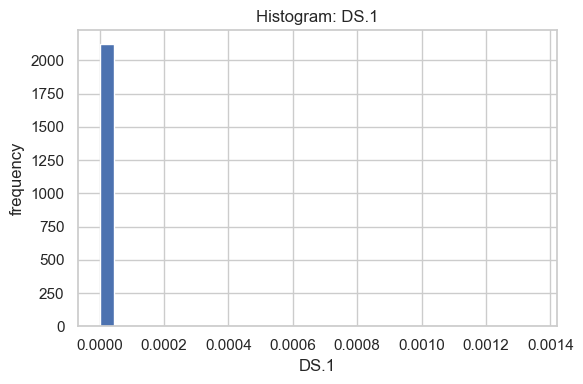

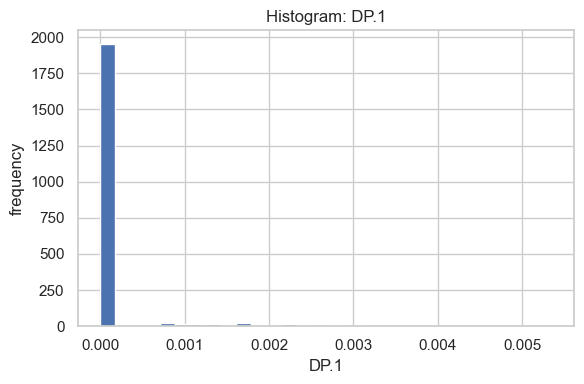

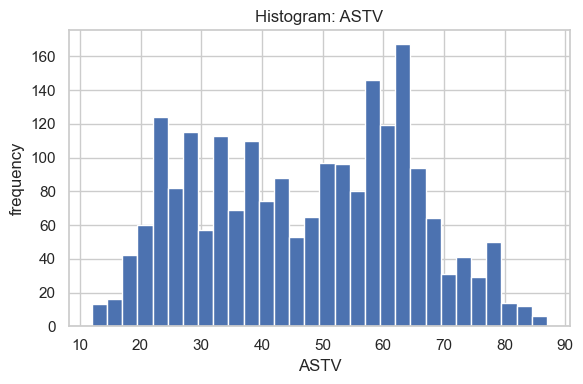

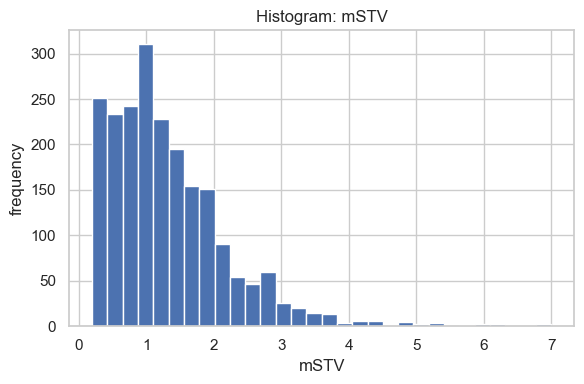

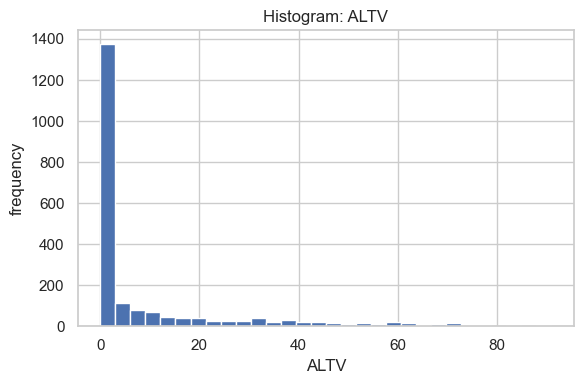

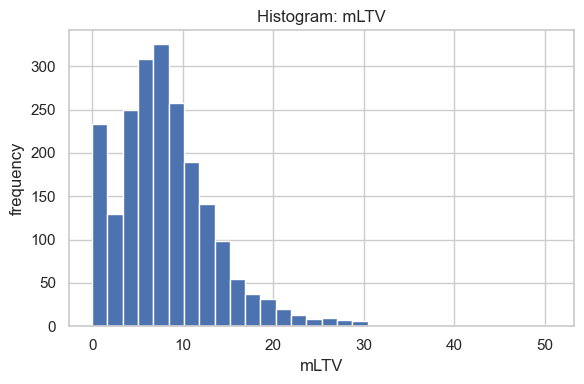

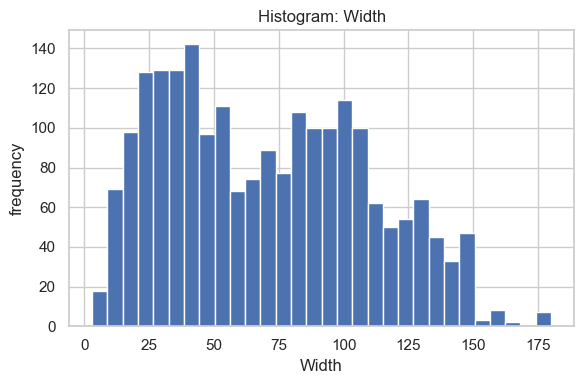

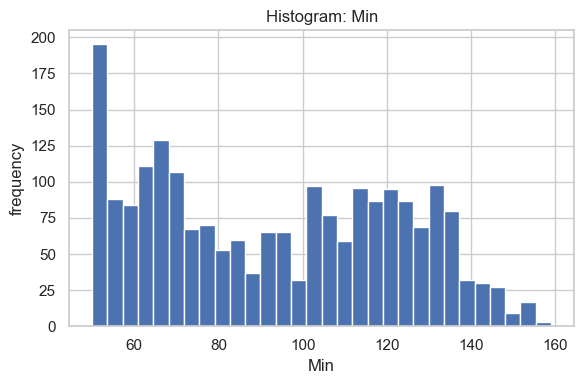

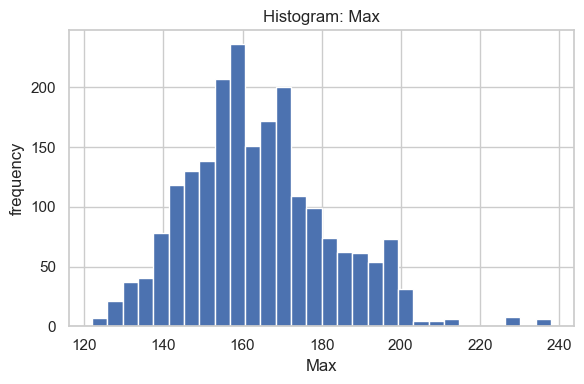

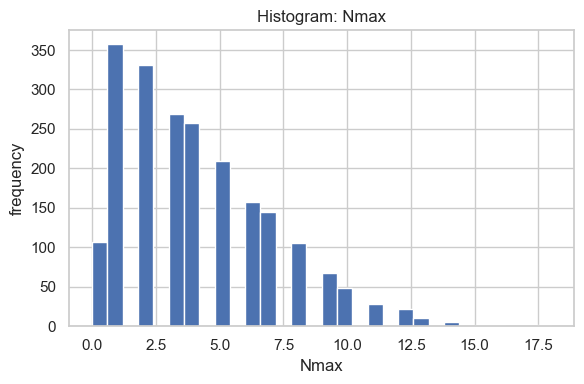

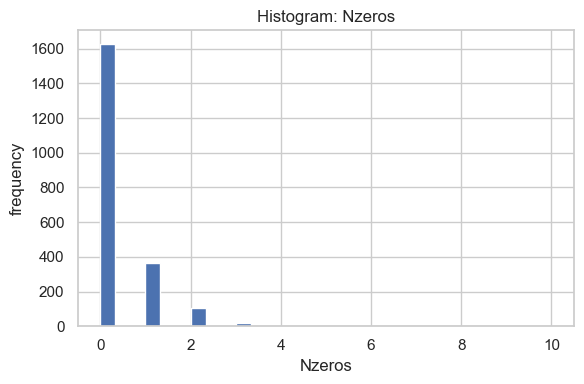

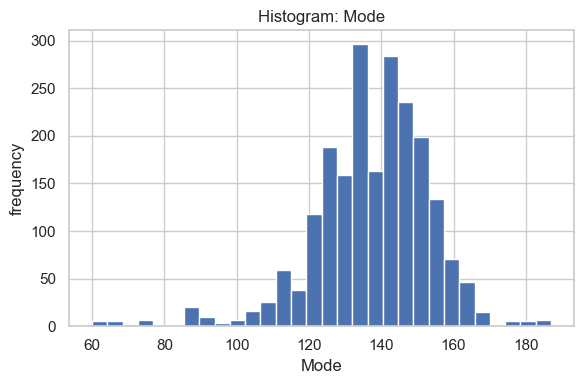

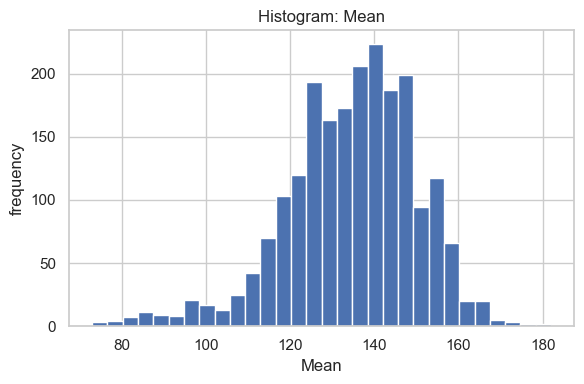

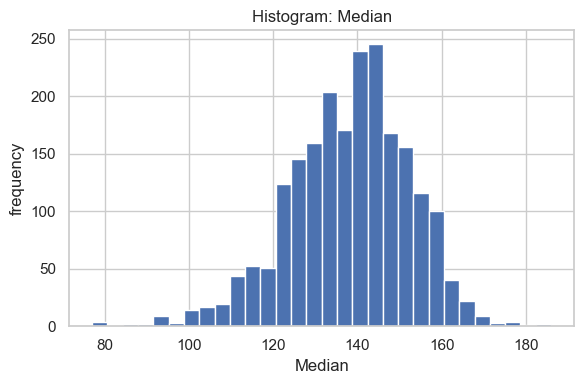

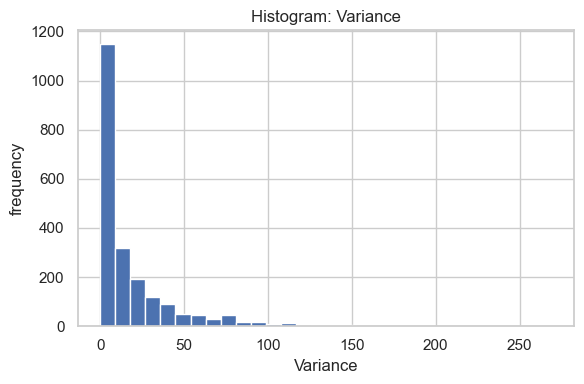

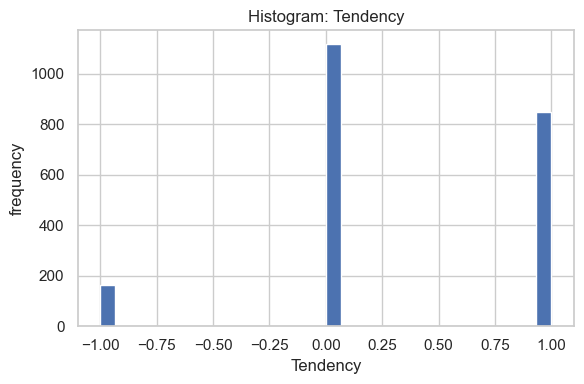

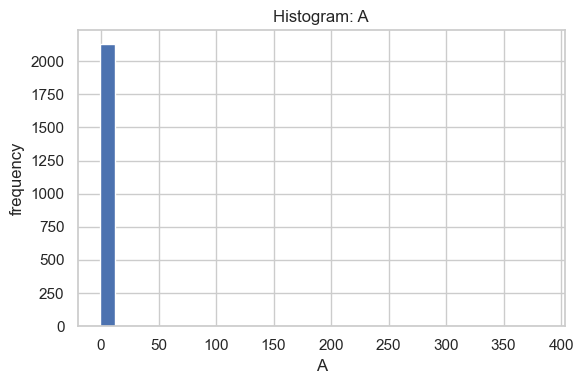

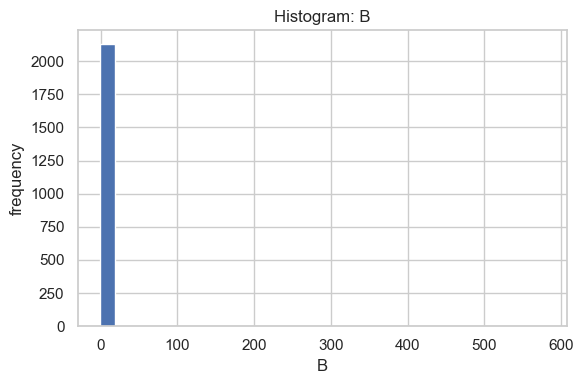

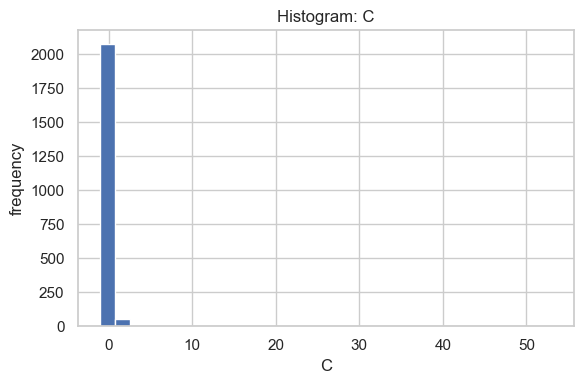

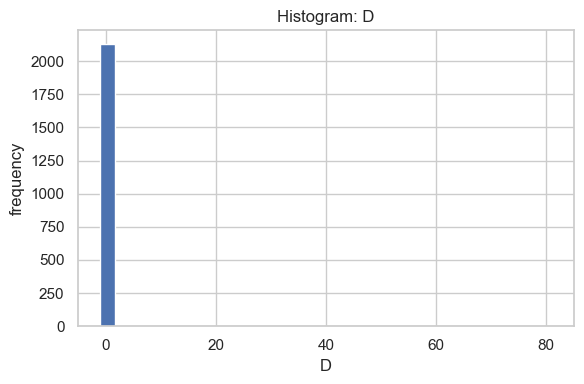

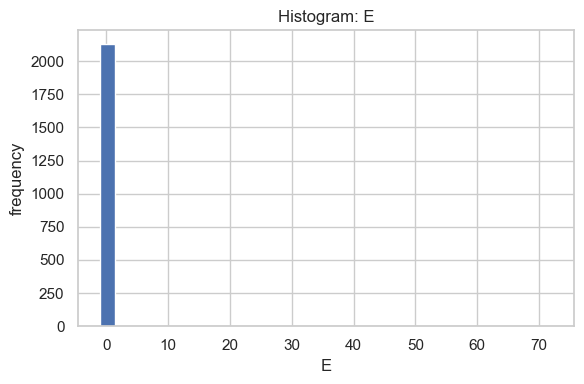

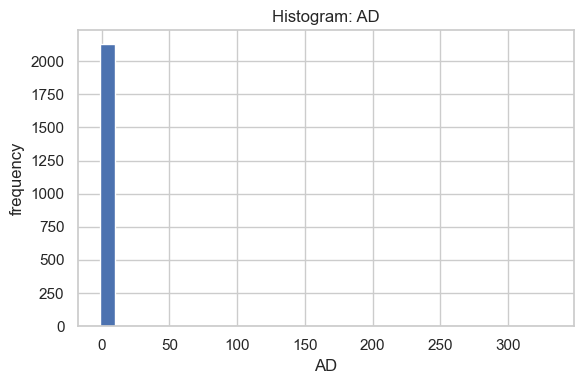

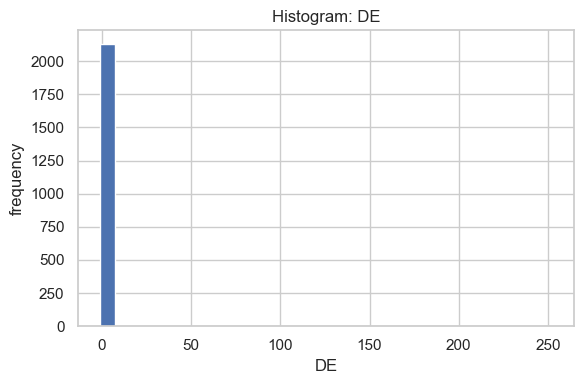

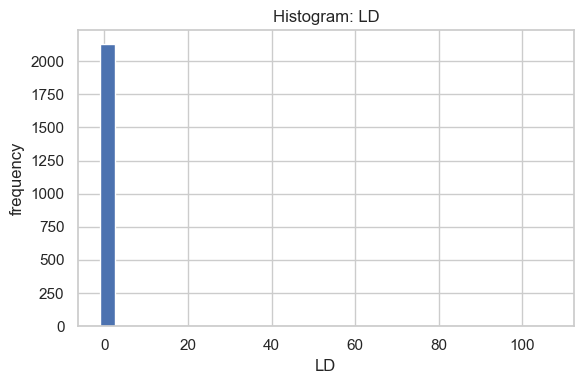

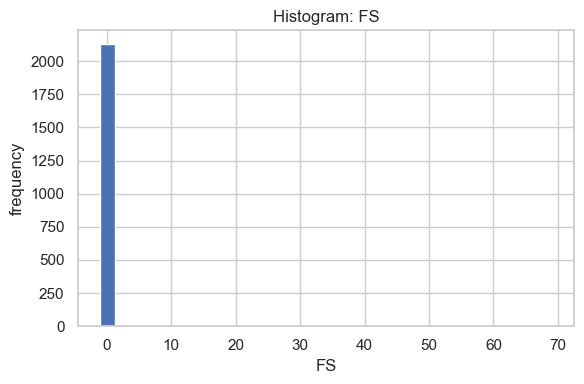

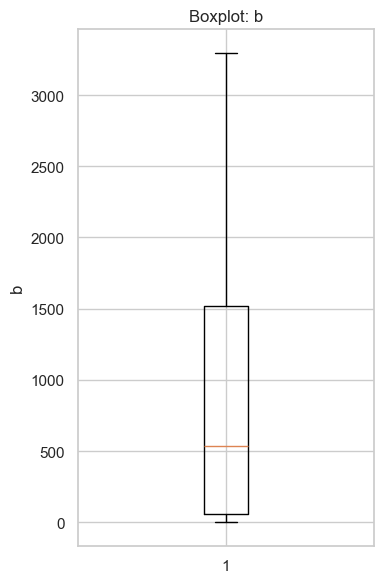

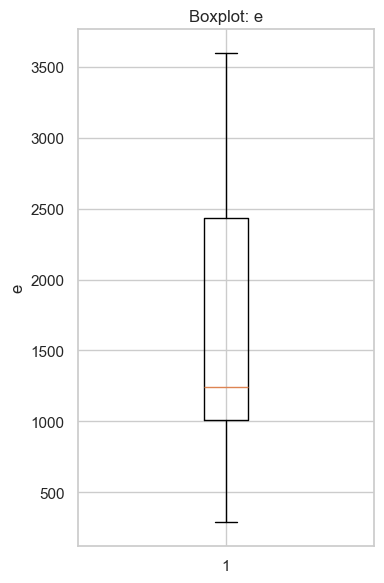

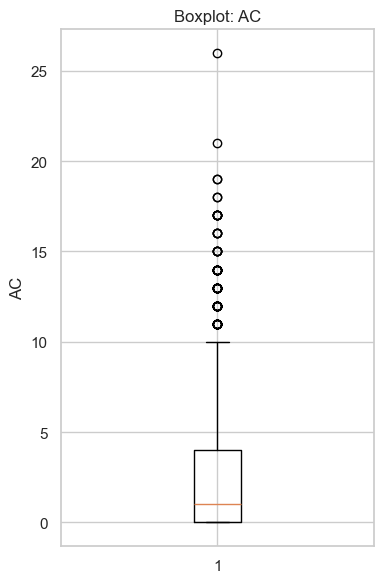

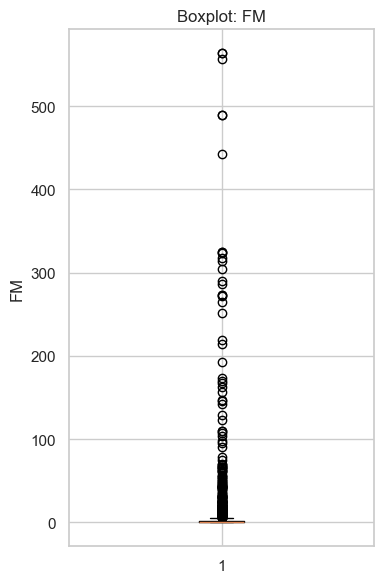

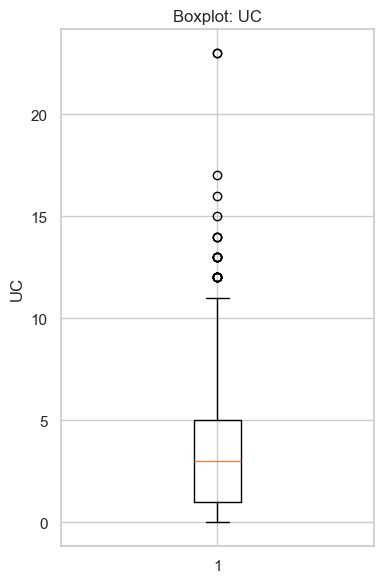

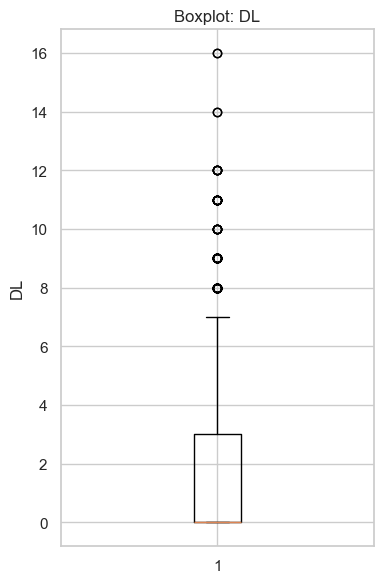

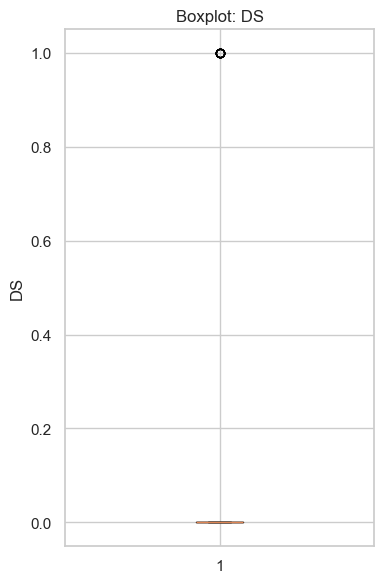

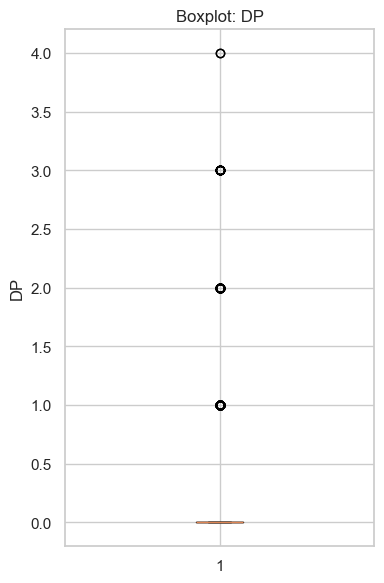

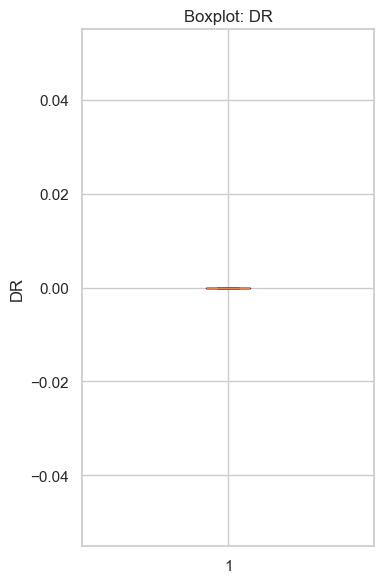

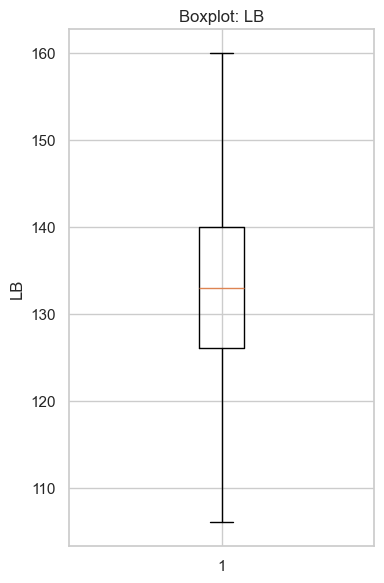

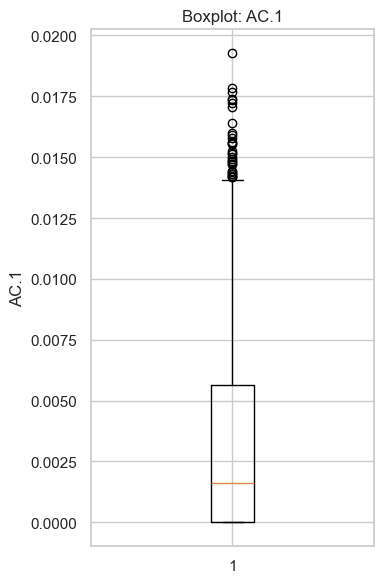

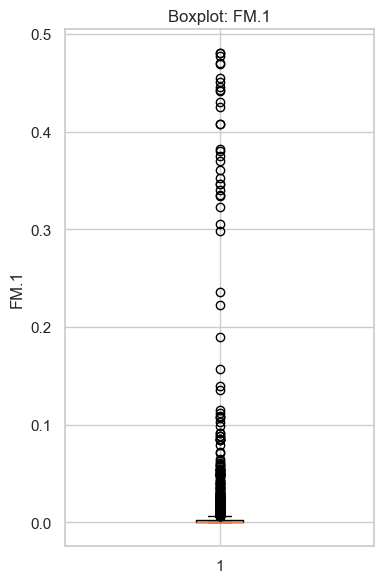

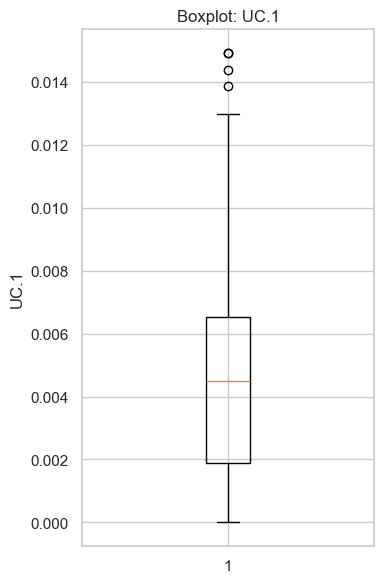

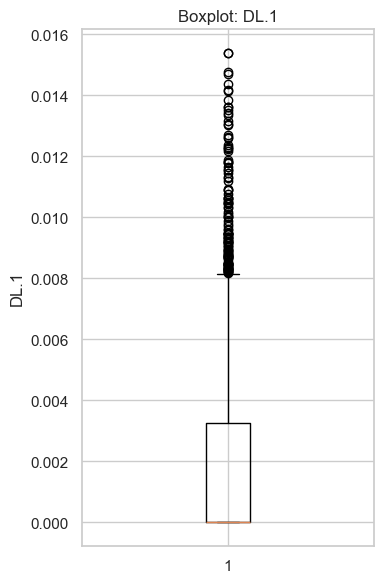

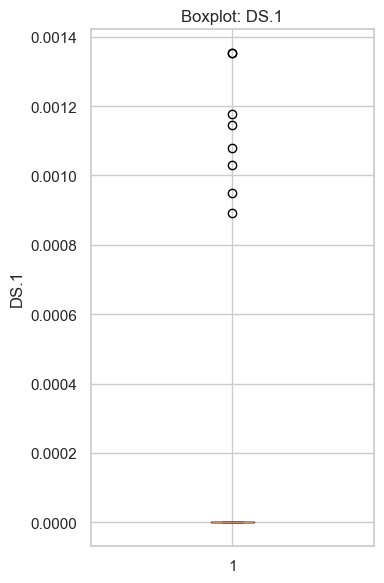

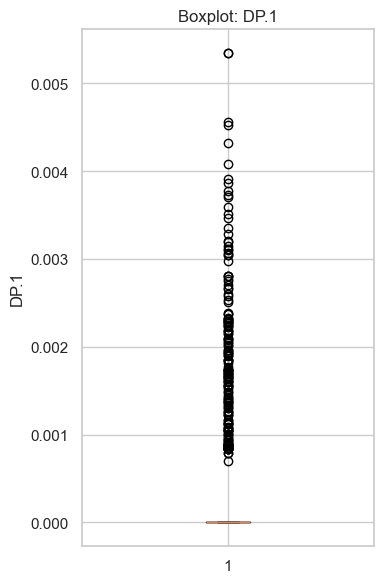

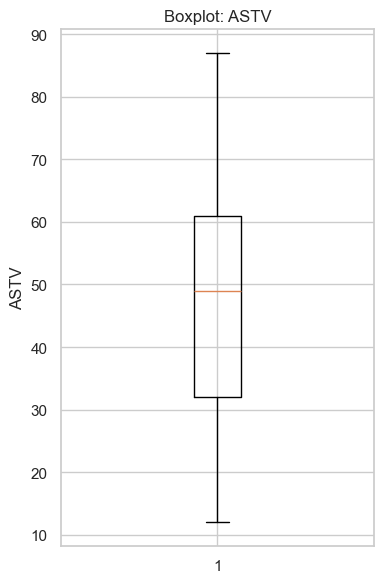

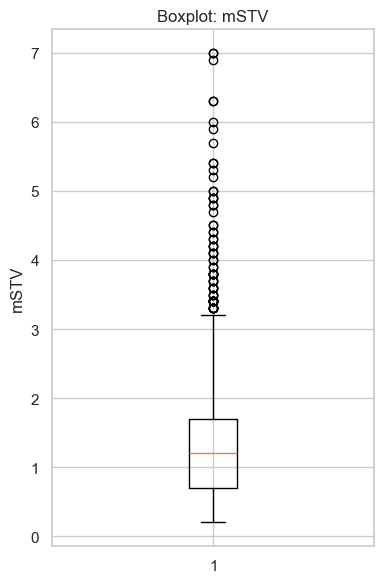

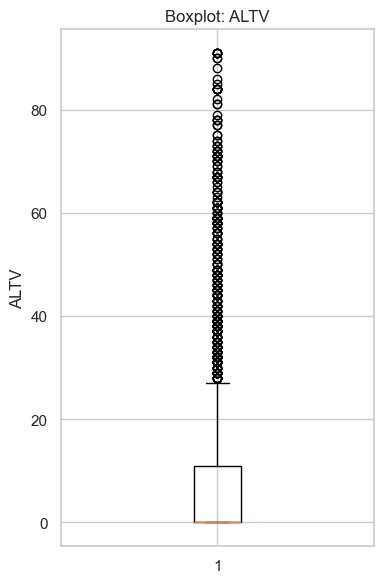

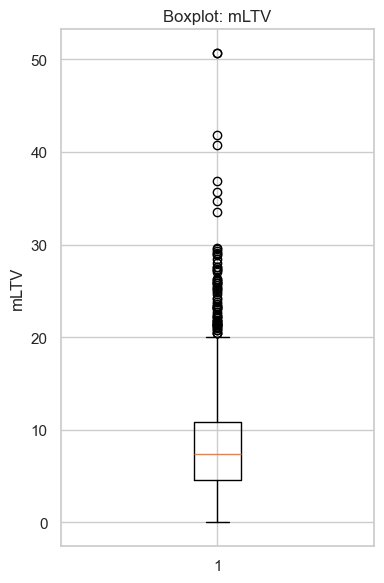

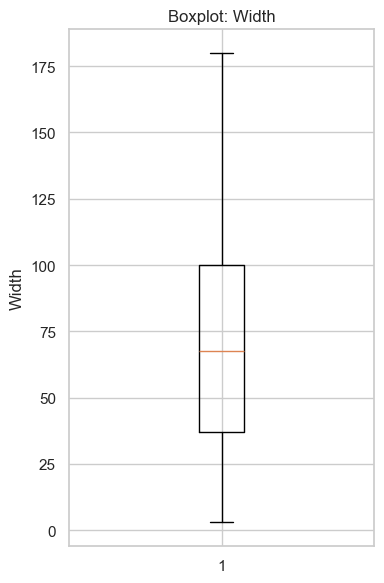

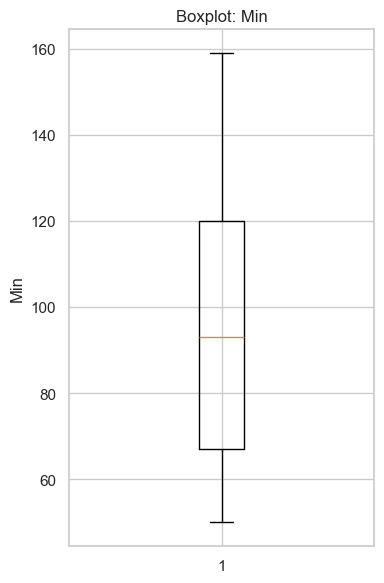

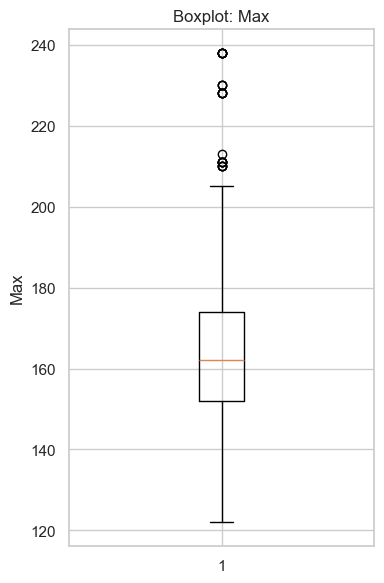

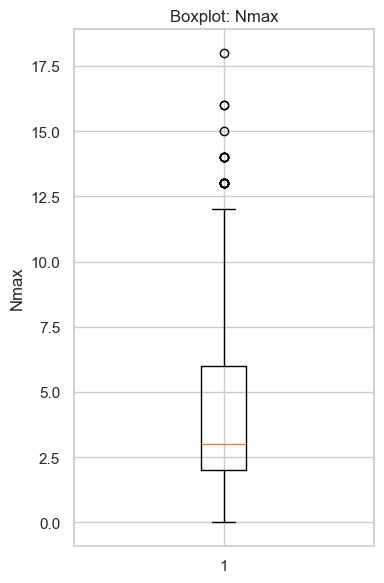

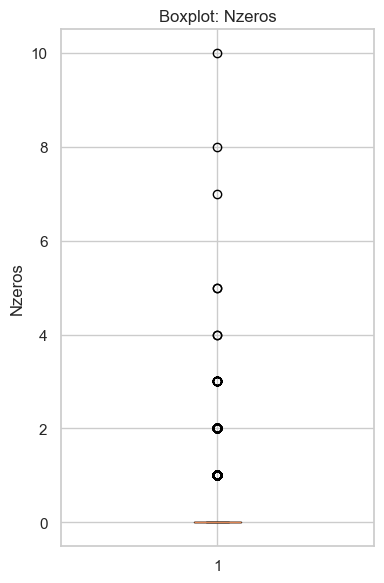

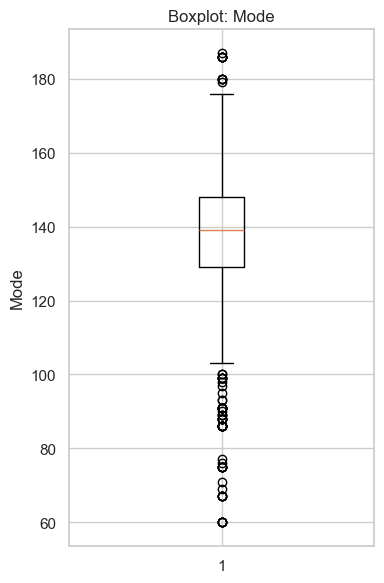

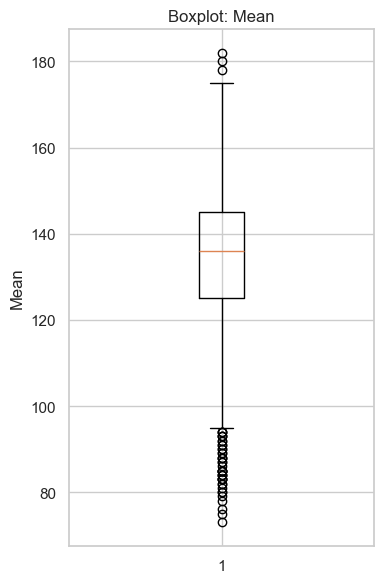

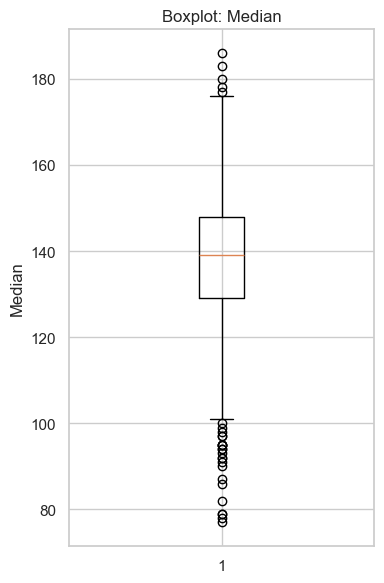

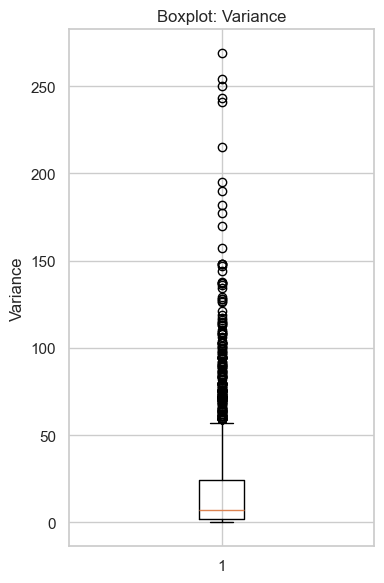

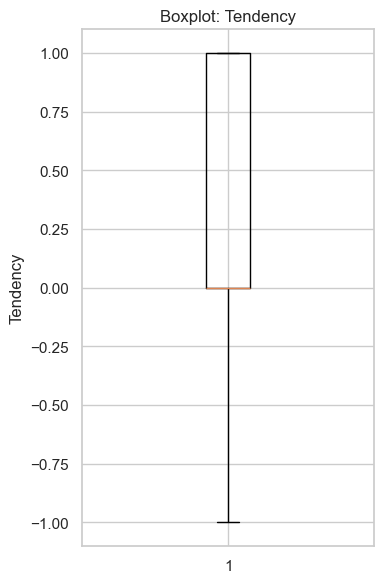

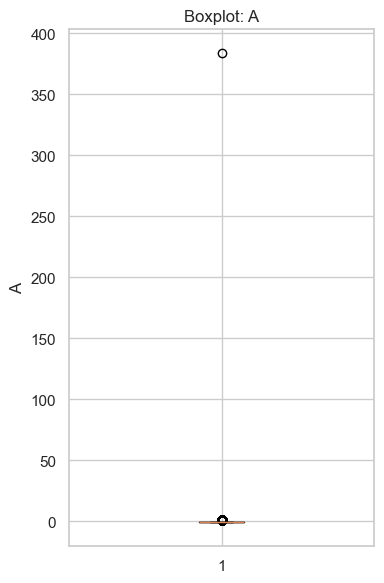

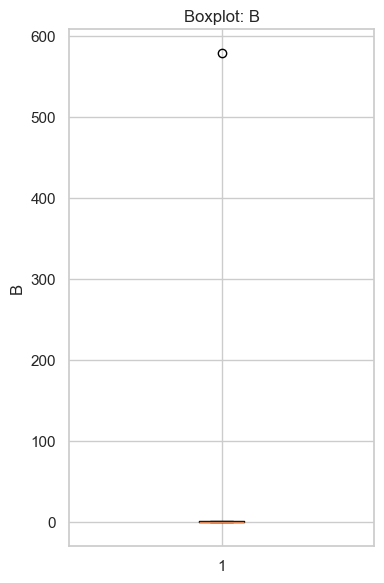

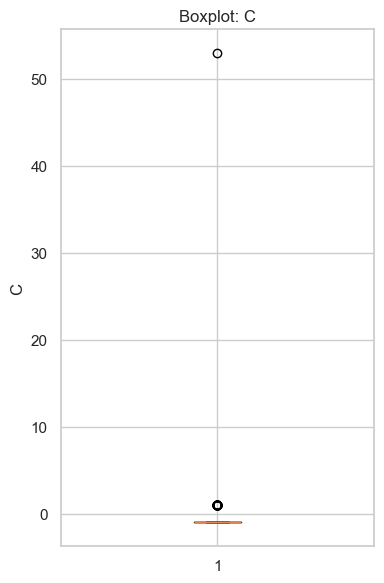

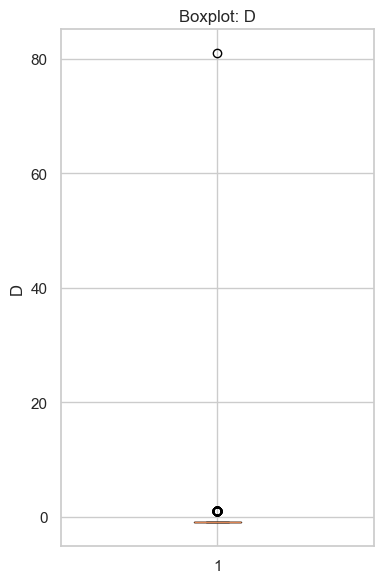

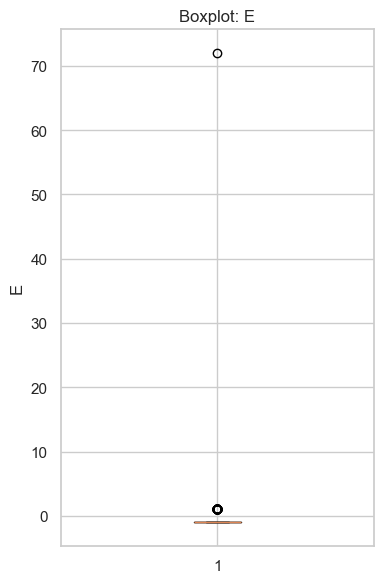

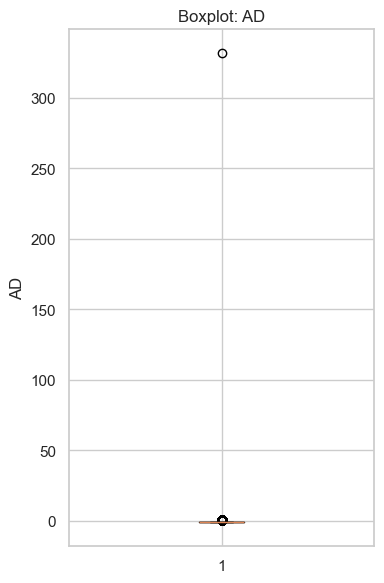

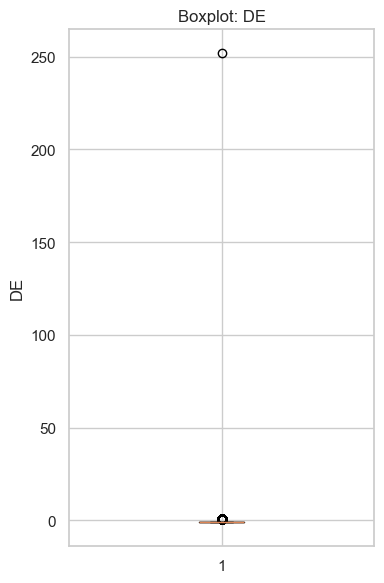

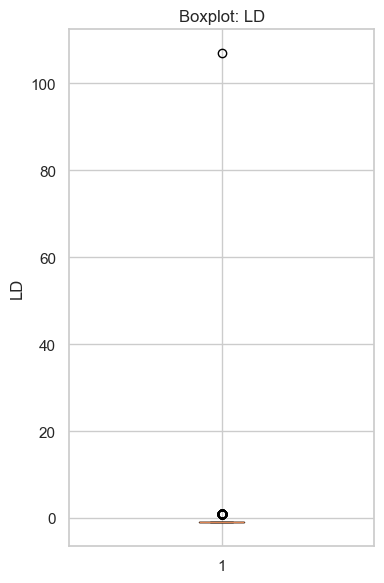

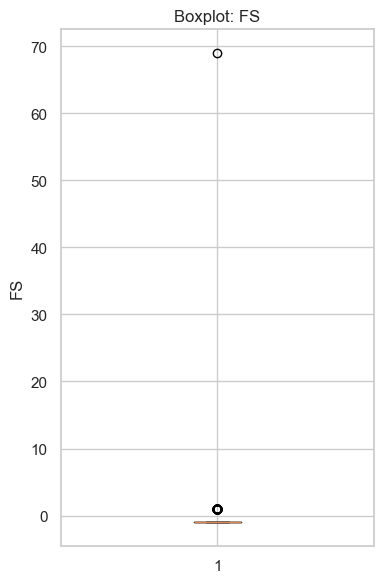

saved histograms + boxplots for 39 features -> ctg_plots


In [55]:
# ===== histograms + boxplots for all numeric features =====

# Assign the DataFrame to a variable (can be changed if using a different DataFrame)
df = sheet2  

# Set up the output directory for saving plots and create it if it doesn't exist
out_dir = Path("ctg_plots")
out_dir.mkdir(parents=True, exist_ok=True)

# Optionally exclude target columns from plotting
possible_targets = {"NSP", "CLASS", "SUSP"}  # common target column names
exclude_cols = [c for c in df.columns if c.upper() in possible_targets]

# Select only numeric columns from the DataFrame
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target columns from the numeric features to avoid plotting them
num_feature_cols = [c for c in num_cols if c not in exclude_cols]

# Ensure the output directory exists (redundant but safe)
out_dir = Path("ctg_plots")
out_dir.mkdir(parents=True, exist_ok=True)

# ===== Create histograms for each numeric feature =====
for c in num_feature_cols:
    plt.figure(figsize=(6, 4))  # set figure size
    plt.hist(df[c].dropna(), bins=30)  # plot histogram with 30 bins, ignoring missing values
    plt.xlabel(c)  # set x-axis label as feature name
    plt.ylabel("frequency")  # set y-axis label
    plt.title(f"Histogram: {c}")  # set plot title
    plt.tight_layout()  # adjust layout to prevent clipping
    plt.savefig(out_dir / f"hist_{c}.png", dpi=200)  # save histogram as PNG
    plt.show()  # display the plot

# ===== Create boxplots for each numeric feature =====
for c in num_feature_cols:
    plt.figure(figsize=(4, 6))  # set figure size
    plt.boxplot(df[c].dropna().values, vert=True, whis=1.5, showfliers=True)  
    # plot vertical boxplot, whiskers at 1.5 IQR, show outliers
    plt.ylabel(c)  # label y-axis with feature name
    plt.title(f"Boxplot: {c}")  # set plot title
    plt.tight_layout()  # adjust layout
    plt.savefig(out_dir / f"box_{c}.png", dpi=200)  # save boxplot as PNG
    plt.show()  # display the plot

# Print summary of how many plots were saved and the directory
print(f"saved histograms + boxplots for {len(num_feature_cols)} features -> {out_dir}")


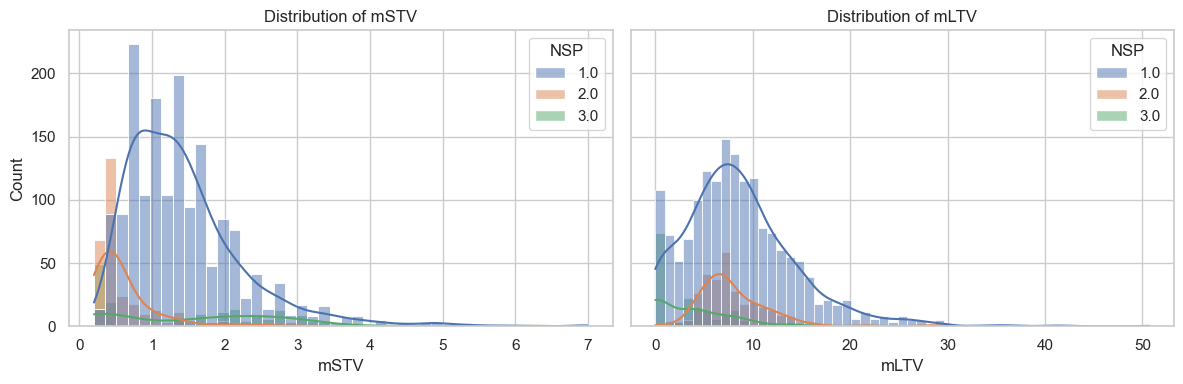

In [56]:
# Create a figure with 1 row and 2 columns of subplots, sharing the y-axis
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Loop through each subplot axis and the corresponding feature
for ax, feature in zip(axes, ['mSTV', 'mLTV']):
    # If the feature is not present in the DataFrame, hide the subplot and skip
    if feature not in clean_df.columns:
        ax.set_visible(False)
        continue
    
    # Plot a histogram of the feature, colored by the target variable
    # kde=True adds a kernel density estimate curve
    # common_norm=False ensures each hue category is normalized independently
    # ax=ax specifies which subplot to draw on, palette='deep' sets colors
    sns.histplot(data=clean_df, x=feature, hue=target_col, kde=True,
                 common_norm=False, ax=ax, palette='deep')
    
    # Set the title for the subplot
    ax.set_title(f'Distribution of {feature}')

# Adjust layout to prevent overlap of labels and titles
plt.tight_layout()

# Display the figure
plt.show()


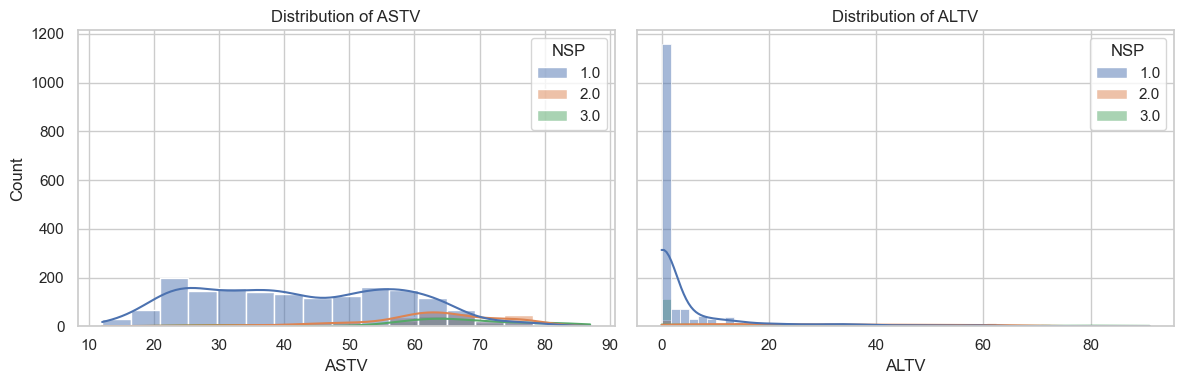

In [57]:

# Create a figure with 1 row and 2 columns of subplots, sharing the y-axis
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Loop through each subplot axis and the corresponding feature
for ax, feature in zip(axes, ['ASTV', 'ALTV']):
    # If the feature is not present in the DataFrame, hide the subplot and skip
    if feature not in clean_df.columns:
        ax.set_visible(False)
        continue
    
    # Plot a histogram of the feature, separated by target variable categories
    # kde=True adds a kernel density estimate curve
    # common_norm=False ensures each hue category is normalized independently
    # ax=ax specifies which subplot to draw on, palette='deep' sets the colors
    sns.histplot(data=clean_df, x=feature, hue=target_col, kde=True,
                 common_norm=False, ax=ax, palette='deep')
    
    # Set the title for each subplot
    ax.set_title(f'Distribution of {feature}')

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Display the figure with the histograms
plt.show()


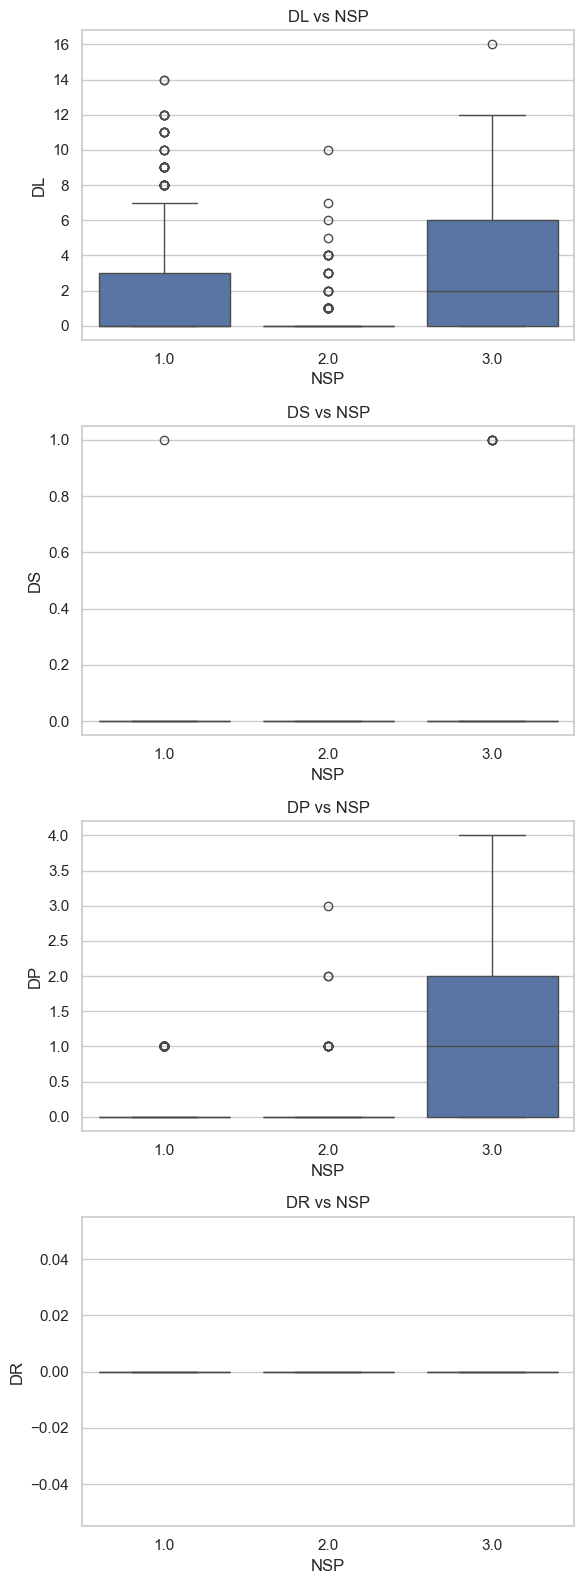

In [58]:
# Select features for boxplots, keeping only those that exist in the DataFrame
box_features = [col for col in ['DL', 'DS', 'DP', 'DR'] if col in clean_df.columns]

# Set up the figure size dynamically based on the number of features
plt.figure(figsize=(6, 4 * len(box_features)))

# Loop through each feature and create a subplot for it
for idx, feature in enumerate(box_features, start=1):
    # Create a subplot in a vertical stack (len(box_features) rows, 1 column)
    ax = plt.subplot(len(box_features), 1, idx)
    
    # Plot a boxplot of the feature against the target variable
    sns.boxplot(data=clean_df, x=target_col, y=feature, ax=ax)
    
    # Set the title for the subplot
    ax.set_title(f'{feature} vs NSP')

# Adjust layout to prevent overlap of subplots and titles
plt.tight_layout()

# Display all boxplots
plt.show()


In [98]:
# Select the relevant columns for LB and NSP
X_lb = clean_df[['LB']]  # Feature: LB
y_lb = clean_df['NSP']   # Target: NSP

# Split the data into train and test sets
X_train_lb, X_test_lb, y_train_lb, y_test_lb = train_test_split(X_lb, y_lb, test_size=0.3, random_state=42, stratify=y_lb)

# Create a pipeline for Logistic Regression
log_reg_pipeline_lb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced', solver='lbfgs'))
])

# Fit the model and evaluate
log_reg_pipeline_lb.fit(X_train_lb, y_train_lb)
y_pred_lb = log_reg_pipeline_lb.predict(X_test_lb)

# Print evaluation results
print("Logistic Regression (LB vs NSP) — Balanced Accuracy:", balanced_accuracy_score(y_test_lb, y_pred_lb))
print("Logistic Regression (LB vs NSP) — Macro F1:", f1_score(y_test_lb, y_pred_lb, average='macro'))
print(classification_report(y_test_lb, y_pred_lb))

Logistic Regression (LB vs NSP) — Balanced Accuracy: 0.5165103020117915
Logistic Regression (LB vs NSP) — Macro F1: 0.31385298995285477
              precision    recall  f1-score   support

           1       0.87      0.21      0.33       494
           2       0.31      0.91      0.46        88
           3       0.09      0.43      0.15        53

    accuracy                           0.32       635
   macro avg       0.42      0.52      0.31       635
weighted avg       0.73      0.32      0.34       635



C:\Users\debor\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [100]:
# Select the relevant columns for AC and NSP
X_ac = clean_df[['AC']]  # Feature: AC
y_ac = clean_df['NSP']   # Target: NSP

# Split the data into train and test sets
X_train_ac, X_test_ac, y_train_ac, y_test_ac = train_test_split(X_ac, y_ac, test_size=0.3, random_state=42, stratify=y_ac)

# Create a pipeline for Logistic Regression
log_reg_pipeline_ac = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced', solver='lbfgs'))
])

# Fit the model and evaluate
log_reg_pipeline_ac.fit(X_train_ac, y_train_ac)
y_pred_ac = log_reg_pipeline_ac.predict(X_test_ac)

# Print evaluation results
print("Logistic Regression (AC vs NSP) — Balanced Accuracy:", balanced_accuracy_score(y_test_ac, y_pred_ac))
print("Logistic Regression (AC vs NSP) — Macro F1:", f1_score(y_test_ac, y_pred_ac, average='macro'))
print(classification_report(y_test_ac, y_pred_ac))

Logistic Regression (AC vs NSP) — Balanced Accuracy: 0.5130456269979606
Logistic Regression (AC vs NSP) — Macro F1: 0.4152519150319642
              precision    recall  f1-score   support

           1       0.99      0.59      0.74       494
           2       0.28      0.84      0.42        88
           3       0.08      0.11      0.09        53

    accuracy                           0.58       635
   macro avg       0.45      0.51      0.42       635
weighted avg       0.82      0.58      0.64       635



C:\Users\debor\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [62]:
# Set the path to the CTG Excel file
ctg_path = Path("ctg.xlsx")

# Ensure that the Excel file exists at the specified path
assert ctg_path.exists(), f"Expected Excel file at {ctg_path.resolve()}"

# Define a function to read and tidy the engineered feature sheet
def read_feature_sheet(path: Path, sheet=1):
    """
    Load the CTG feature sheet from an Excel file.
    Uses row 2 (header=1) as column headers and data from row 3 onward.
    """
    # Open the Excel file
    xls = pd.ExcelFile(path)
    
    # Determine the sheet name if an integer index is provided
    sheet_name = xls.sheet_names[sheet] if isinstance(sheet, int) else sheet
    
    try:
        # Try reading the sheet using row 2 as headers
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        # Fallback: use the first row as headers if the above fails
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    
    # Return the loaded DataFrame
    return df

# Load the features from sheet 1 of the Excel file
raw_features = read_feature_sheet(ctg_path, sheet=1)

# Display the shape of the loaded DataFrame
raw_features.shape


(2129, 46)

In [64]:
# Define a function to clean and tidy the feature sheet
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    cleaned = df.copy()  # Work on a copy to avoid modifying the original DataFrame
    
    # Strip whitespace from column names
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    
    # Drop rows and columns that are completely empty
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    
    # Remove columns with names starting with 'Unnamed' (often from Excel artifacts)
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    
    # Remove duplicated column names
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    
    # Define a mapping to standardize column names
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    
    # Rename columns based on the mapping, only if they exist in the DataFrame
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    
    return cleaned

# Apply the tidy function to the raw features
sheet2 = tidy_sheet(raw_features)

# Define the target column
target_col = 'NSP'

# Define columns that may cause label leakage and should be dropped
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']

# Identify feature columns by excluding target and label leakage columns
feature_cols = [col for col in sheet2.columns if col not in label_leak_cols + [target_col]]

# Create a cleaned DataFrame by dropping label leakage columns, empty rows, and duplicate rows
clean_df = (
    sheet2
    .drop(columns=label_leak_cols, errors='ignore')
    .dropna(axis=0, how='all')
    .drop_duplicates()
)

# Coerce feature columns to numeric, setting invalid parsing to NaN
numeric_cols = feature_cols
clean_df[numeric_cols] = clean_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows where the target is missing
clean_df = clean_df.dropna(subset=[target_col]).copy()

# Ensure the target column is integer type
clean_df[target_col] = clean_df[target_col].astype(int)

# Separate features (X) and target (y)
X = clean_df[numeric_cols]
y = clean_df[target_col]

# Output the shape of the feature matrix and value counts of the target
X.shape, y.value_counts().sort_index()


((2115, 30),
 NSP
 1    1647
 2     293
 3     175
 Name: count, dtype: int64)

In [66]:
# Split the dataset into training and testing sets
# test_size=0.3 means 30% of the data is reserved for testing
# random_state=42 ensures reproducibility
# stratify=y preserves the class distribution in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Print the shapes of the resulting training and testing feature sets
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

# Create a DataFrame to show the proportion of each class in train and test sets
pd.DataFrame({
    'Split': ['Train', 'Test'],
    'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],       # proportion of class 1
    'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],      # proportion of class 2
    'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]    # proportion of class 3
}).rename(columns=lambda c: c if c == 'Split' else f'{c} proportion')  # Rename columns to indicate they are proportions


Train shape: (1480, 30)
Test shape: (635, 30)


,Split,Normal (1) proportion,Suspect (2) proportion,Pathologic (3) proportion
0,Train,0.78,0.14,0.08
1,Test,0.78,0.14,0.08


In [68]:
# Stratified split of the dataset into training and testing sets
# Ensures the class distribution is preserved in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Get the unique class labels in the training set
classes = np.unique(y_train)

# Compute class weights to handle class imbalance
# 'balanced' option automatically adjusts weights inversely proportional to class frequencies
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Convert class weights into a dictionary mapping class label -> weight
class_weight_dict = dict(zip(classes, class_weight_values))

# Compute sample-wise weights for the training set based on class weights
# Useful for training models that accept sample weights
sample_weight_train = compute_sample_weight(class_weight='balanced', y=y_train)

# Create a DataFrame summarizing the train/test distribution and class proportions
distribution = (
    pd.DataFrame({
        'Split': ['Train', 'Test'],
        'Size': [len(y_train), len(y_test)],  # number of samples in each split
        'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],       # proportion of class 1
        'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],      # proportion of class 2
        'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]    # proportion of class 3
    })
    .rename(columns=lambda c: c if c in {'Split', 'Size'} else f'{c} proportion')  # rename columns to indicate proportions
)

# Display the distribution DataFrame and the class weight dictionary
distribution, class_weight_dict


(   Split  Size  Normal (1) proportion  Suspect (2) proportion  \
 0  Train  1480                   0.78                    0.14   
 1   Test   635                   0.78                    0.14   
 
    Pathologic (3) proportion  
 0                       0.08  
 1                       0.08  ,
 {1: 0.4278693263949118, 2: 2.4065040650406506, 3: 4.043715846994536})

In [70]:
# Initialize a list to store evaluation results for different models
results = []

# Define a helper function to train, evaluate, and display results for a model
def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=False):
    """
    Train a model, predict on test data, and compute evaluation metrics.
    
    Parameters:
        name (str): Model name for display and tracking.
        estimator: Scikit-learn compatible estimator.
        X_train, y_train: Training features and labels.
        X_test, y_test: Testing features and labels.
        fit_kwargs (dict, optional): Additional keyword arguments for estimator.fit().
        display_report (bool): Whether to print detailed classification report.
        
    Returns:
        estimator: Trained estimator.
        y_pred: Predictions on X_test.
    """
    # Use provided fit arguments or an empty dictionary
    fit_kwargs = fit_kwargs or {}
    
    # Fit the estimator on the training data
    estimator.fit(X_train, y_train, **fit_kwargs)
    
    # Predict on the test set
    y_pred = estimator.predict(X_test)
    
    # Compute balanced accuracy (accounts for class imbalance)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    # Compute macro F1 score (average F1 across all classes)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Append results to the global results list
    results.append({'Model': name, 'Balanced Accuracy': bal_acc, 'F1 Macro': f1})
    
    # Print a summary of the model's performance
    print(f"{name} — Balanced Accuracy: {bal_acc:.3f}, Macro F1: {f1:.3f}")
    
    # Optionally display a detailed classification report
    if display_report:
        print(classification_report(y_test, y_pred, digits=3))
    
    # Plot a normalized confusion matrix for visual evaluation
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=sorted(classes), normalize='true', cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()
    
    # Return the trained estimator and predictions
    return estimator, y_pred

# Show the class labels used for evaluation
classes


array([1, 2, 3])

C:\Users\debor\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression — Balanced Accuracy: 0.831, Macro F1: 0.786
              precision    recall  f1-score   support

           1      0.980     0.889     0.932       494
           2      0.549     0.830     0.661        88
           3      0.759     0.774     0.766        53

    accuracy                          0.871       635
   macro avg      0.763     0.831     0.786       635
weighted avg      0.902     0.871     0.881       635



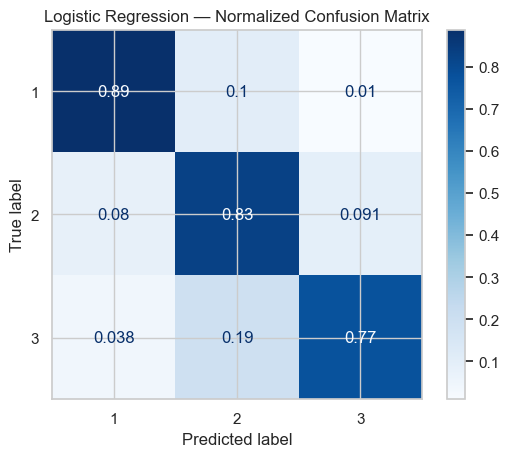

In [72]:
# Create a machine learning pipeline for logistic regression
log_reg_pipeline = Pipeline(steps=[
    # Step 1: Impute missing values using the median of each feature
    ('imputer', SimpleImputer(strategy='median')),
    
    # Step 2: Standardize features by removing the mean and scaling to unit variance
    ('scaler', StandardScaler()),
    
    # Step 3: Logistic Regression model
    ('log_reg', LogisticRegression(
        max_iter=1000,               # Maximum number of iterations for convergence
        multi_class='multinomial',   # Handle multiclass classification natively
        class_weight='balanced',     # Adjust weights inversely proportional to class frequencies
        solver='lbfgs'               # Optimization algorithm for fitting
    ))
])

# Train, evaluate, and display performance for the logistic regression pipeline
# display_report=True prints a detailed classification report
_ = evaluate_model(
    'Logistic Regression', 
    log_reg_pipeline, 
    X_train, y_train, X_test, y_test, 
    display_report=True
)


Decision Tree — Balanced Accuracy: 0.872, Macro F1: 0.839


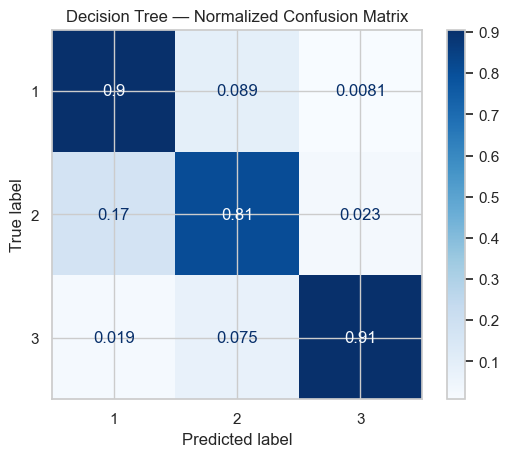

In [74]:
# Create a machine learning pipeline for a decision tree classifier
tree_pipeline = Pipeline(steps=[
    # Step 1: Impute missing values using the median of each feature
    ('imputer', SimpleImputer(strategy='median')),
    
    # Step 2: Decision Tree model
    ('tree', DecisionTreeClassifier(
        criterion='gini',           # Use Gini impurity to measure split quality
        min_samples_leaf=5,         # Minimum number of samples required at a leaf node
        max_depth=None,             # No maximum depth (tree can grow until stopping criteria are met)
        class_weight='balanced',    # Adjust weights inversely proportional to class frequencies
        random_state=42             # Seed for reproducibility
    ))
])

# Train, evaluate, and display performance for the decision tree pipeline
_ = evaluate_model(
    'Decision Tree', 
    tree_pipeline, 
    X_train, y_train, X_test, y_test
)


Random Forest — Balanced Accuracy: 0.915, Macro F1: 0.911


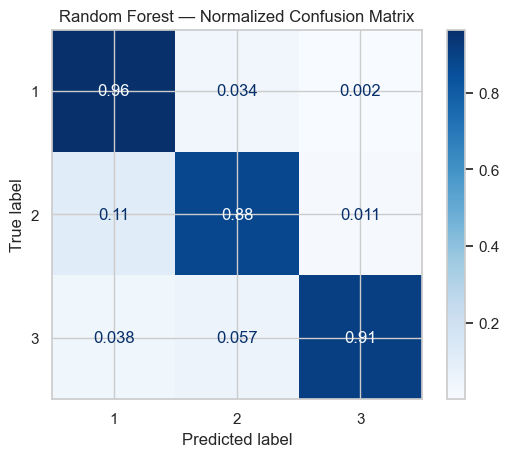

In [76]:
# Create a machine learning pipeline for a random forest classifier
rf_pipeline = Pipeline(steps=[
    # Step 1: Impute missing values using the median of each feature
    ('imputer', SimpleImputer(strategy='median')),
    
    # Step 2: Random Forest model
    ('rf', RandomForestClassifier(
        n_estimators=300,           # Number of trees in the forest
        max_depth=None,             # No maximum depth (trees grow until stopping criteria are met)
        min_samples_leaf=4,         # Minimum number of samples required at a leaf node
        class_weight='balanced',    # Adjust weights inversely proportional to class frequencies
        random_state=42,            # Seed for reproducibility
        n_jobs=-1                   # Use all available CPU cores for parallel processing
    ))
])

# Train, evaluate, and display performance for the random forest pipeline
_ = evaluate_model(
    'Random Forest', 
    rf_pipeline, 
    X_train, y_train, X_test, y_test
)


Gradient Boosting — Balanced Accuracy: 0.911, Macro F1: 0.921


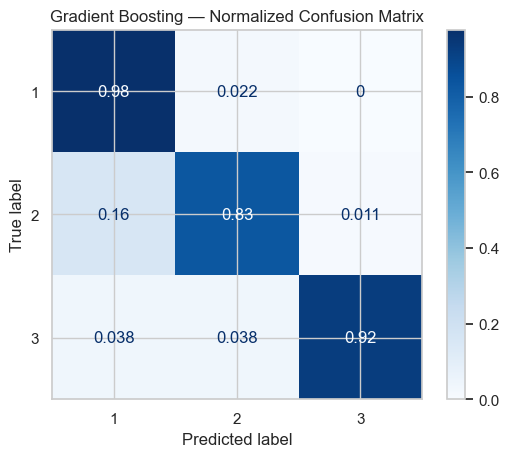

In [78]:
# Create a machine learning pipeline for gradient boosting classifier
gb_pipeline = Pipeline(steps=[
    # Step 1: Impute missing values using the median of each feature
    ('imputer', SimpleImputer(strategy='median')),
    
    # Step 2: Gradient Boosting model
    ('gb', GradientBoostingClassifier(
        n_estimators=300,       # Number of boosting stages (trees)
        learning_rate=0.05,     # Step size shrinkage to prevent overfitting
        max_depth=3,            # Maximum depth of individual trees (shallow trees for boosting)
        random_state=42         # Seed for reproducibility
    ))
])

# Provide sample weights for training to handle class imbalance
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}

# Train, evaluate, and display performance for the gradient boosting pipeline
# fit_kwargs passes the sample weights to the GradientBoostingClassifier
_ = evaluate_model(
    'Gradient Boosting', 
    gb_pipeline, 
    X_train, y_train, X_test, y_test, 
    fit_kwargs=gb_fit_kwargs
)


Neural Network (MLP) — Balanced Accuracy: 0.801, Macro F1: 0.832


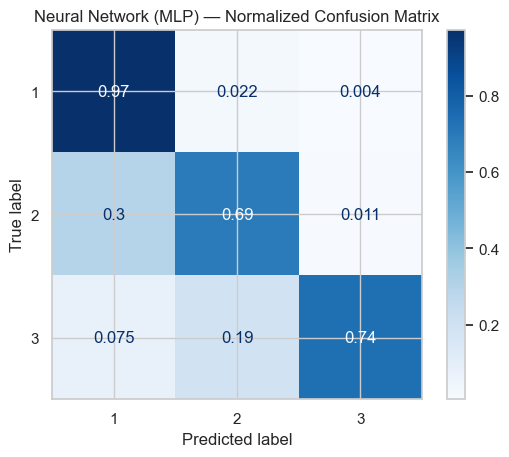

In [79]:
# Create a machine learning pipeline for a Multi-Layer Perceptron (Neural Network) classifier
mlp_pipeline = Pipeline(steps=[
    # Step 1: Impute missing values using the median of each feature
    ('imputer', SimpleImputer(strategy='median')),
    
    # Step 2: Standardize features to zero mean and unit variance
    ('scaler', StandardScaler()),
    
    # Step 3: Multi-Layer Perceptron classifier
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),  # Two hidden layers with 64 and 32 neurons
        activation='relu',             # Rectified Linear Unit activation function
        alpha=1e-3,                    # L2 regularization term to prevent overfitting
        learning_rate='adaptive',      # Adjust learning rate based on performance
        max_iter=1000,                 # Maximum number of iterations for training
        early_stopping=True,           # Stop training early if validation score stops improving
        random_state=42                # Seed for reproducibility
    ))
])

# Train, evaluate, and display performance for the MLP neural network pipeline
_ = evaluate_model(
    'Neural Network (MLP)', 
    mlp_pipeline, 
    X_train, y_train, X_test, y_test
)


k-Nearest Neighbors — Balanced Accuracy: 0.722, Macro F1: 0.771


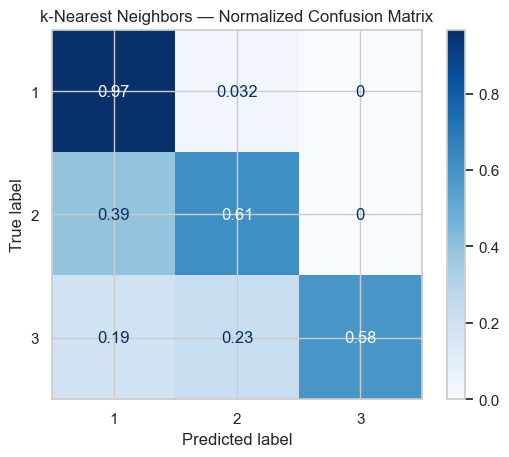

In [82]:
# Create a machine learning pipeline for k-Nearest Neighbors classifier
knn_pipeline = Pipeline(steps=[
    # Step 1: Impute missing values using the median of each feature
    ('imputer', SimpleImputer(strategy='median')),
    
    # Step 2: Standardize features to zero mean and unit variance
    ('scaler', StandardScaler()),
    
    # Step 3: k-Nearest Neighbors classifier
    ('knn', KNeighborsClassifier(n_neighbors=15))  # Use 15 nearest neighbors for classification
])

# Train, evaluate, and display performance for the k-NN pipeline
_ = evaluate_model(
    'k-Nearest Neighbors', 
    knn_pipeline, 
    X_train, y_train, X_test, y_test
)


In [84]:
# Create a DataFrame from the results list, which contains evaluation metrics for all models
results_df = pd.DataFrame(results)

# Sort the DataFrame by Balanced Accuracy in descending order to see the best-performing models first
results_df = results_df.sort_values('Balanced Accuracy', ascending=False)

# Reset the index to clean up after sorting
results_df.reset_index(drop=True)


,Model,Balanced Accuracy,F1 Macro
0,Random Forest,0.91,0.91
1,Gradient Boosting,0.91,0.92
2,Decision Tree,0.87,0.84
3,Logistic Regression,0.83,0.79
4,Neural Network (MLP),0.80,0.83
5,k-Nearest Neighbors,0.72,0.77


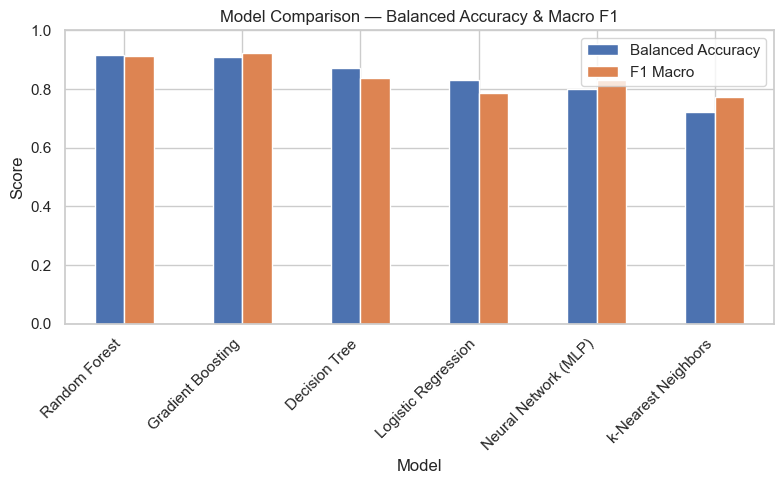

In [86]:
# Create a figure for visual comparison of model performance
fig, ax = plt.subplots(figsize=(8, 5))

# Plot a bar chart comparing Balanced Accuracy and Macro F1 for each model
results_df.plot(
    x='Model',                           # Use model names on the x-axis
    y=['Balanced Accuracy', 'F1 Macro'], # Plot both metrics as bars
    kind='bar',                          # Bar chart
    ax=ax                                 # Plot on the created axes
)

# Set y-axis limits from 0 to 1 since these are proportion metrics
ax.set_ylim(0, 1)

# Label the y-axis
ax.set_ylabel('Score')

# Set the title of the plot
ax.set_title('Model Comparison — Balanced Accuracy & Macro F1')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent clipping of labels and title
plt.tight_layout()

# Display the plot
plt.show()


In [88]:
# Import SMOTE for oversampling minority classes
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with a fixed random state for reproducibility
sm = SMOTE(random_state=42)

# Apply SMOTE to the training data to balance class distributions
# X_res and y_res are the resampled features and labels
X_res, y_res = sm.fit_resample(X_train, y_train)

# Initialize a Random Forest classifier
rf_sm = RandomForestClassifier(
    n_estimators=200,   # Number of trees in the forest
    random_state=42      # Seed for reproducibility
)

# Train the Random Forest on the SMOTE-resampled data
rf_sm.fit(X_res, y_res)

# Predict on the original test set
y_pred_rf_sm = rf_sm.predict(X_test)

# Compute and print the balanced accuracy for the Random Forest trained with SMOTE
print("RF+SMOTE Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rf_sm))

# Compute and print the macro F1 score for the Random Forest trained with SMOTE
print("RF+SMOTE Macro F1:", f1_score(y_test, y_pred_rf_sm, average="macro"))


RF+SMOTE Balanced Accuracy: 0.9091895773871941
RF+SMOTE Macro F1: 0.9107901835988305


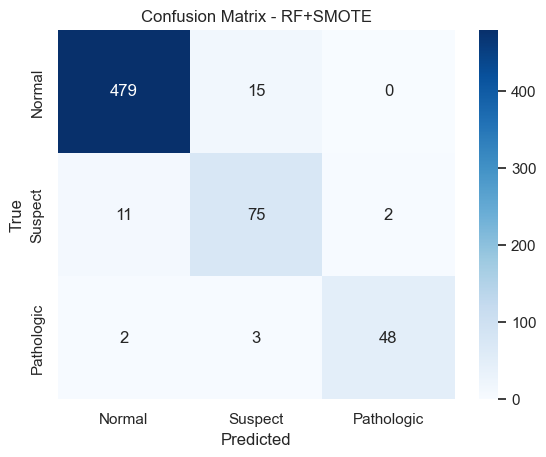

In [90]:
# Import confusion_matrix from scikit-learn and seaborn for visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix for the RF+SMOTE predictions
cm = confusion_matrix(y_test, y_pred_rf_sm)

# Plot the confusion matrix as a heatmap
sns.heatmap(
    cm,                           # Confusion matrix values
    annot=True,                   # Show the numbers in each cell
    fmt="d",                      # Format numbers as integers
    cmap="Blues",                 # Color map for the heatmap
    xticklabels=["Normal","Suspect","Pathologic"],  # Labels for x-axis (predicted)
    yticklabels=["Normal","Suspect","Pathologic"]   # Labels for y-axis (true)
)

# Label the axes
plt.xlabel("Predicted")
plt.ylabel("True")

# Set the plot title
plt.title("Confusion Matrix - RF+SMOTE")

# Display the heatmap
plt.show()



=== Random Forest Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        48
  Pathologic       1.00      1.00      1.00       100
     Suspect       1.00      1.00      1.00        52

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

=== Confusion Matrix ===


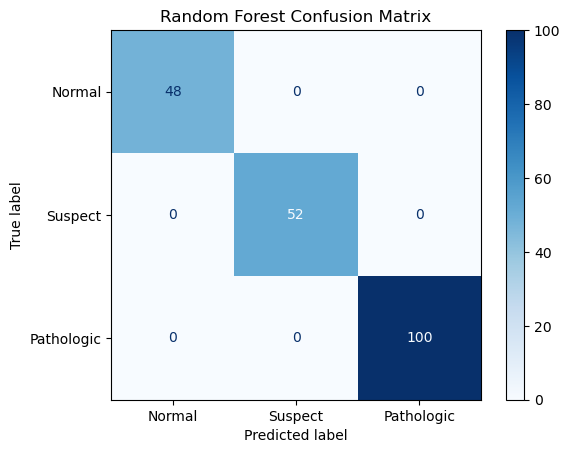


=== Feature Importances ===
cat__Deceleration_variable     0.171540
cat__Deceleration_late         0.147678
cat__Deceleration_prolonged    0.133221
cat__Variability_low           0.118041
cat__Deceleration_none         0.108256
cat__Deceleration_early        0.098252
cat__Variability_absent        0.070815
cat__Acceleration_absent       0.035287
cat__Acceleration_present      0.033686
cat__Variability_normal        0.032534
cat__Variability_marked        0.029112
remainder__LB                  0.021578
dtype: float64


In [67]:
import matplotlib.pyplot as plt

# -----------------------------------------
# STEP 1: Example Synthetic Data (replace with your sheet2 data if available)
# -----------------------------------------
np.random.seed(42)
n = 1000
X = pd.DataFrame({
    'LB': np.random.randint(110, 170, size=n),
    'Variability': np.random.choice(['absent', 'low', 'normal', 'marked'], size=n),
    'Acceleration': np.random.choice(['present', 'absent'], size=n),
    'Deceleration': np.random.choice(['none', 'variable', 'early', 'late', 'prolonged'], size=n)
})

# Simple labeling rules to simulate classification
def rule(lb, var, ac, decel):
    if lb < 110 or lb > 170:
        return 'Pathologic'
    if decel in ('late', 'prolonged'):
        return 'Pathologic'
    if var == 'absent' and ac == 'absent':
        return 'Pathologic'
    if var == 'low' or decel == 'variable':
        return 'Suspect'
    return 'Normal'

y = [rule(X.iloc[i,0], X.iloc[i,1], X.iloc[i,2], X.iloc[i,3]) for i in range(len(X))]

# -----------------------------------------
# STEP 2: Preprocessing + Random Forest Pipeline
# -----------------------------------------
cat_features = ['Variability', 'Acceleration', 'Deceleration']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

# -----------------------------------------
# STEP 3: Train-Test Split & Model Training
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

# -----------------------------------------
# STEP 4: Model Evaluation
# -----------------------------------------
y_pred = pipeline.predict(X_test)

print("\n=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred, labels=['Normal', 'Suspect', 'Pathologic'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Suspect', 'Pathologic'])
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# -----------------------------------------
# STEP 5: Feature Importances
# -----------------------------------------
rf_model = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print("\n=== Feature Importances ===")
print(feature_importances)

In [51]:
# ================================
# CTG Predictive Model Prototype
# With Manual User Input
# ================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# ---------------------------------------
# STEP 1: Synthetic Dataset Generation
# ---------------------------------------

np.random.seed(42)

def sample_variability(n):
    return np.random.choice(['absent', 'low', 'normal', 'excessive'], size=n, p=[0.05, 0.2, 0.7, 0.05])

def sample_acceleration(n):
    return np.random.choice(['present', 'absent'], size=n, p=[0.65, 0.35])

def sample_decel(n):
    return np.random.choice(['none', 'variable', 'early', 'late', 'prolonged'],
                            size=n, p=[0.6, 0.2, 0.05, 0.12, 0.03])

def label_from_rules(lb, var, ac, decel):
    """Simple CTG interpretation rule set."""
    if lb < 110 or lb > 170:
        return 'Pathologic'
    if decel in ('late', 'prolonged'):
        return 'Pathologic'
    if var == 'absent' and ac == 'absent':
        return 'Pathologic'
    if lb > 160 and var in ('absent', 'low'):
        return 'Pathologic'
    if var == 'low' or ac == 'absent' or decel == 'variable':
        return 'Suspect'
    return 'Normal'

# Generate synthetic samples
n = 5000
lbs = np.random.normal(loc=140, scale=12, size=n).astype(int)
vars_ = sample_variability(n)
acs = sample_acceleration(n)
decels = sample_decel(n)
labels = [label_from_rules(lbs[i], vars_[i], acs[i], decels[i]) for i in range(n)]

df = pd.DataFrame({
    'LB': lbs,
    'Variability': vars_,
    'Acceleration': acs,
    'Deceleration': decels,
    'Label': labels
})

# ---------------------------------------
# STEP 2: Model Training
# ---------------------------------------

X = df[['LB', 'Variability', 'Acceleration', 'Deceleration']]
y = df['Label']

cat_features = ['Variability', 'Acceleration', 'Deceleration']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

# ---------------------------------------
# STEP 3: Evaluation
# ---------------------------------------

print("\n--- Model Evaluation ---")
y_pred = pipeline.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix (rows=true, cols=pred):\n",
      confusion_matrix(y_test, y_pred, labels=['Normal', 'Suspect', 'Pathologic']))

# ---------------------------------------
# STEP 4: Save Model
# ---------------------------------------

model_filename = "ctg_random_forest.pkl"
joblib.dump(pipeline, model_filename)
print(f"\n✅ Model saved to {model_filename}")

# ---------------------------------------
# STEP 5: User Manual Input
# ---------------------------------------

def predict_ctg(LB, Variability, Acceleration, Deceleration, model_path=model_filename):
    """Load model and predict Normal/Suspect/Pathologic for user input."""
    model = joblib.load(model_path)
    input_df = pd.DataFrame([{
        'LB': int(LB),
        'Variability': Variability.lower(),
        'Acceleration': Acceleration.lower(),
        'Deceleration': Deceleration.lower()
    }])
    pred = model.predict(input_df)[0]
    probs = model.predict_proba(input_df)[0]
    classes = model.classes_
    prob_dict = {classes[i]: round(float(probs[i]), 3) for i in range(len(classes))}
    return pred, prob_dict

# ---------------------------------------
# STEP 6: Console Prompt for Another User
# ---------------------------------------

print("\n--- Manual CTG Prediction ---")
print("Please enter the following values:")

try:
    lb_input = int(input("Enter Baseline Fetal Heart Rate (LB): "))
    var_input = input("Enter Variability (absent / low / normal / excessive): ").strip().lower()
    ac_input = input("Is Acceleration present or absent? ").strip().lower()
    decel_input = input("Enter Deceleration (none / variable / early / late / prolonged): ").strip().lower()

    pred, probs = predict_ctg(lb_input, var_input, ac_input, decel_input)
    print("\n--- Prediction Result ---")
    print(f"Prediction: {pred}")
    print("Probabilities:", probs)
except Exception as e:
    print("Error in input:", e)


--- Model Evaluation ---

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       330
  Pathologic       0.99      0.98      0.99       187
     Suspect       0.99      1.00      1.00       483

    accuracy                           1.00      1000
   macro avg       1.00      0.99      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix (rows=true, cols=pred):
 [[330   0   0]
 [  0 482   1]
 [  0   3 184]]

✅ Model saved to ctg_random_forest.pkl

--- Manual CTG Prediction ---
Please enter the following values:


Enter Baseline Fetal Heart Rate (LB):  160
Enter Variability (absent / low / normal / excessive):  normal 
Is Acceleration present or absent?  present 
Enter Deceleration (none / variable / early / late / prolonged):  variable 



--- Prediction Result ---
Prediction: Suspect
Probabilities: {'Normal': 0.0, 'Pathologic': 0.0, 'Suspect': 1.0}


In [1]:
# ===== histograms + boxplots for all numeric features =====

# Assign the DataFrame to a variable (same as before)
df = sheet2

# Set up the output directory for saving plots and create it if it doesn't exist
out_dir = Path("ctg_plots")
out_dir.mkdir(parents=True, exist_ok=True)

# Optionally exclude target columns from plotting
possible_targets = {"NSP", "CLASS", "SUSP"}  # common target column names
exclude_cols = [c for c in df.columns if c.upper() in possible_targets]

# Select only numeric columns from the DataFrame
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target columns from the numeric features to avoid plotting them
num_feature_cols = [c for c in num_cols if c not in exclude_cols]

# ===== Create histograms for each numeric feature =====
for c in num_feature_cols:
    plt.figure(figsize=(6, 4))
    
    # Scale only FM during plotting
    data = df[c].dropna() * 1000 if c == "FM" else df[c].dropna()
    
    plt.hist(data, bins=30)
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.title(f"Histogram: {c}" + (" (scaled x1000)" if c == "FM" else ""))
    plt.tight_layout()
    plt.savefig(out_dir / f"hist_{c}.png", dpi=200)
    plt.show()

# ===== Create boxplots for each numeric feature =====
for c in num_feature_cols:
    plt.figure(figsize=(4, 6))
    
    # Scale only FM during plotting
    data = df[c].dropna().values * 1000 if c == "FM" else df[c].dropna().values
    
    plt.boxplot(data, vert=True, whis=1.5, showfliers=True)
    plt.ylabel(c)
    plt.title(f"Boxplot: {c}" + (" (scaled x1000)" if c == "FM" else ""))
    plt.tight_layout()
    plt.savefig(out_dir / f"box_{c}.png", dpi=200)
    plt.show()

# Print summary of how many plots were saved and the directory
print(f"Saved histograms + boxplots for {len(num_feature_cols)} features -> {out_dir}")



NameError: name 'sheet2' is not defined